<a href="https://colab.research.google.com/github/Elvin26/DATATHON_4/blob/main/%EA%B6%8C%EC%A7%80%EC%98%88/%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%86%A4_4%ED%8C%80_%EA%B6%8C%EC%A7%80%EC%98%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#라이브러리 정리 및 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import seaborn as sns
import matplotlib.patches as patches
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

In [ ]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

In [ ]:
df_final = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/shinhan/data_final.csv") #1번 데이터셋 불러오기
df_final_1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/shinhan/shinhan_final_1.csv") #2번 데이터셋 불러오기
df_m = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/shinhan/전처리완료_정렬.csv") #3번 데이터셋 불러오기

# 데이터 추가 전처리

## 1번 데이터셋 전처리

In [ ]:
df_final.replace(-999999.9, np.nan, inplace=True) #결측치 처리

In [ ]:
df_final['폐업여부'] = df_final['폐업일'].notna().astype(int) #폐업여부 파생변수 생성, 폐업이면 1, 아니면 0

In [ ]:
#개설일과 폐업일을 datetime 형식으로 변환
df_final['개설일'] = pd.to_datetime(df_final['개설일'], format='%Y-%m-%d')
df_final['폐업일'] = pd.to_datetime(df_final['폐업일'], format='%Y-%m-%d', errors='coerce')

#운영기간 파생변수 생성(폐업 가맹점 : 폐업일 - 개설일, 운영중 가맹점 : 2024-12-31 - 개설일)
end_date = pd.to_datetime('2024-12-31')
df_final['운영기간'] = (df_final['폐업일'].fillna(end_date) - df_final['개설일']).dt.days

In [ ]:
df_cleaned = df_final.dropna(subset=['12개월_업종대비_평균매출_비율', '폐업여부']).copy()
print(f"'12개월_업종대비_평균매출_비율' 컬럼의 데이터 타입: {df_cleaned['12개월_업종대비_평균매출_비율'].dtype}")
print(f"'폐업여부' 컬럼의 데이터 타입: {df_cleaned['폐업여부'].dtype}")
print(f"결측치 처리 후 DataFrame의 행 수: {len(df_cleaned)}")

'12개월_업종대비_평균매출_비율' 컬럼의 데이터 타입: float64
'폐업여부' 컬럼의 데이터 타입: int64
결측치 처리 후 DataFrame의 행 수: 86278


In [ ]:
df_closed_stores = df_final[df_final['폐업여부'] == 1].copy()

print(f"'재방문고객_비중' 컬럼의 결측치 개수 (처리 전): {df_closed_stores['재방문고객_비중'].isnull().sum()}개")
df_closed_stores.dropna(subset=['재방문고객_비중'], inplace=True)
print(f"'재방문고객_비중' 컬럼의 결측치 개수 (처리 후): {df_closed_stores['재방문고객_비중'].isnull().sum()}개")

print(f"'기준년월_dt' 컬럼의 현재 데이터 타입: {df_closed_stores['기준년월_dt'].dtype}")
if not pd.api.types.is_datetime64_any_dtype(df_closed_stores['기준년월_dt']):
    df_closed_stores['기준년월_dt'] = pd.to_datetime(df_closed_stores['기준년월_dt'])
    print(f"'기준년월_dt' 컬럼을 datetime 형식으로 변환 완료. 새 데이터 타입: {df_closed_stores['기준년월_dt'].dtype}")
else:
    print(f"'기준년월_dt' 컬럼은 이미 datetime 형식입니다.")

print(f"필터링 및 결측치 처리 후 df_closed_stores의 행 수: {len(df_closed_stores)}")

'재방문고객_비중' 컬럼의 결측치 개수 (처리 전): 88개
'재방문고객_비중' 컬럼의 결측치 개수 (처리 후): 0개
'기준년월_dt' 컬럼의 현재 데이터 타입: object
'기준년월_dt' 컬럼을 datetime 형식으로 변환 완료. 새 데이터 타입: datetime64[ns]
필터링 및 결측치 처리 후 df_closed_stores의 행 수: 2246


In [ ]:
df_filtered_closed_23_24 = df_closed_stores[df_closed_stores['폐업일'].dt.year.isin([2023, 2024])].copy()

print("df_filtered_closed_23_24의 상위 5개 행:")
print(df_filtered_closed_23_24.head())
print(f"\ndf_filtered_closed_23_24의 행 수: {len(df_filtered_closed_23_24)}")

df_filtered_closed_23_24의 상위 5개 행:
          가맹점구분번호             가맹점주소  가맹점명 브랜드구분코드  가맹점_지역         업종   상권  \
12671  1E00B3CC15  서울 성동구 용답29길 28.  럼프**     NaN  서울 성동구  한식-단품요리일반  답십리   
12672  1E00B3CC15  서울 성동구 용답29길 28.  럼프**     NaN  서울 성동구  한식-단품요리일반  답십리   
12673  1E00B3CC15  서울 성동구 용답29길 28.  럼프**     NaN  서울 성동구  한식-단품요리일반  답십리   
12674  1E00B3CC15  서울 성동구 용답29길 28.  럼프**     NaN  서울 성동구  한식-단품요리일반  답십리   
12675  1E00B3CC15  서울 성동구 용답29길 28.  럼프**     NaN  서울 성동구  한식-단품요리일반  답십리   

             개설일        폐업일         위도          경도    기준년월  운영개월수_구간  월매출_구간  \
12671 2014-10-29 2023-05-04  37.564925  127.053542  202302         3       6   
12672 2014-10-29 2023-05-04  37.564925  127.053542  202303         3       6   
12673 2014-10-29 2023-05-04  37.564925  127.053542  202301         3       6   
12674 2014-10-29 2023-05-04  37.564925  127.053542  202305         6       6   
12675 2014-10-29 2023-05-04  37.564925  127.053542  202304         3       6   

       월매출건수_구간  월고객수

## 2번 데이터셋 전처리

In [ ]:
df_final_1.replace(-999999.9, np.nan, inplace=True) #결측치 처리

In [ ]:
# 중분류 카테고리 매핑 딕셔너리
category_map = {
    # 한식 음식점업
    '한식-육류/고기': '한식 음식점업', '한식-찌개/전골': '한식 음식점업', '한식-국밥/설렁탕': '한식 음식점업',
    '한식-해물/생선': '한식 음식점업', '한식-국수/만두': '한식 음식점업', '한식-단품요리일반': '한식 음식점업',
    '백반/가정식': '한식 음식점업', '한식-감자탕': '한식 음식점업', '한식-냉면': '한식 음식점업', '한식-죽': '한식 음식점업',
    '한식-두부요리': '한식 음식점업', '기사식당': '한식 음식점업', '한정식': '한식 음식점업',

    #구내식당 및 뷔페
    '한식뷔페': '구내식당 및 뷔페', '구내식당/푸드코트': '구내식당 및 뷔페',

    # 중식/일식/양식/세계음식
    '중식당': '중식 음식점업', '중식-훠궈/마라탕': '중식 음식점업', '중식-딤섬/중식만두': '중식 음식점업',
    '일식당': '일식 음식점업', '일식-덮밥/돈가스': '일식 음식점업', '일식-초밥/롤': '일식 음식점업',
    '일식-우동/소바/라면': '일식 음식점업', '일식-참치회': '일식 음식점업','꼬치구이': '일식 음식점업',
    '일식-샤브샤브': '일식 음식점업', '양식': '서양식 음식점업', '스테이크': '서양식 음식점업',
    '동남아/인도음식': '동남아시아 음식점업', '기타세계요리': '기타 외국식 음식점업',

    # 기타 간이 음식점업
    '햄버거': '기타 간이 음식점업', '피자': '기타 간이 음식점업', '치킨': '기타 간이 음식점업',
    '샌드위치/토스트': '기타 간이 음식점업', '도시락': '기타 간이 음식점업',
    '포장마차': '기타 간이 음식점업', '분식': '기타 간이 음식점업',
    '떡/한과': '기타 간이 음식점업', '떡/한과 제조': '기타 간이 음식점업','아이스크림/빙수': '기타 간이 음식점업',
    '와플/크로플': '기타 간이 음식점업', '마카롱': '기타 간이 음식점업', '베이커리': '기타 간이 음식점업',
    '도너츠': '기타 간이 음식점업', '탕후루' : '기타 간이 음식점업',

    # 식료품 소매업
    '반찬': '식료품 소매업', '축산물': '식료품 소매업', '식품 제조': '식료품 소매업', '식료품': '식료품 소매업',
    '미곡상': '식료품 소매업', '농산물': '식료품 소매업', '청과물': '식료품 소매업', '수산물': '식료품 소매업',
    '인삼제품': '식료품 소매업', '건어물': '식료품 소매업', '건강식품': '식료품 소매업',
    '유제품': '식료품 소매업', '건강원': '식료품 소매업',

    # 카페/디저트
    '커피전문점': '비알코올 음료점업', '카페': '비알코올 음료점업', '테마카페': '비알코올 음료점업',
    '테이크아웃커피': '비알코올 음료점업', '주스': '비알코올 음료점업', '차': '비알코올 음료점업',

    # 주점/유흥
    '호프/맥주': '주점업', '룸살롱/단란주점': '주점업', '일반 유흥주점': '주점업',
    '민속주점': '주점업', '요리주점': '주점업', '이자카야': '주점업',
    '와인바': '주점업',

    # 논의 필요 (음료 소매업 또는 주점업)
   '와인샵': '음료 소매업', '주류': '음료 소매업',

    # 기타 소매업
   '담배': '담배 소매업'

}

df_final_1["업종중분류"] = df_final_1["업종"].map(category_map).fillna("기타")
print(df_final_1["업종중분류"].value_counts())

업종중분류
한식 음식점업        30178
기타 간이 음식점업     14004
식료품 소매업        13273
비알코올 음료점업      10939
주점업             6111
일식 음식점업         4235
서양식 음식점업        3385
중식 음식점업         2255
동남아시아 음식점업       663
음료 소매업           423
구내식당 및 뷔페        375
담배 소매업           234
기타 외국식 음식점업      203
Name: count, dtype: int64


In [ ]:
df_final_1['배달여부'] = df_final_1['배달매출비율'].apply(
    lambda x: '비배달매장' if x == -999999.9 else '배달매장'
)

In [ ]:
# 사용할 컬럼 리스트
use_cols = [
    '가맹점구분번호', '운영개월수_구간', '월매출_구간', '월매출건수_구간', '월고객수_구간', '객단가_구간',
    '배달매출비율', '12개월_업종대비_평균매출_비율', '12개월_업종대비_평균매출건수_비율',
    '12개월_업종내_매출_백분위', '12개월_동일업종_폐업가맹점_비중', '12개월_동일상권_폐업가맹점_비중',
    '재방문고객_비중', '신규고객_비중', '거주지고객_비중', '직장이고객_비중', '유동인구고객_비중',
    '기준년월_dt', '상권클러스터', '업종중분류','배달여부','개설일','폐업일'
]

# ✅ 지정한 컬럼만 남기기
df_final_1 = df_final_1[use_cols]

# 결과 확인
print(df_final_1.shape)
print(df_final_1.head())

# 저장
df_final_1.to_csv("data_filtered.csv", index=False)

(86278, 23)
      가맹점구분번호  운영개월수_구간  월매출_구간  월매출건수_구간  월고객수_구간  객단가_구간  배달매출비율  \
0  000F03E44A         5       6         5        5       4     NaN   
1  000F03E44A         5       6         6        6       6     NaN   
2  000F03E44A         5       6         6        6       6     NaN   
3  000F03E44A         5       6         5        5       3     NaN   
4  000F03E44A         5       6         5        5       6     NaN   

   12개월_업종대비_평균매출_비율  12개월_업종대비_평균매출건수_비율  12개월_업종내_매출_백분위  \
0                0.5                  1.1             95.3   
1                0.0                  0.0             95.2   
2                0.0                  0.0             95.0   
3                1.3                  1.0             94.5   
4                0.0                  1.0             94.6   

   12개월_동일업종_폐업가맹점_비중  12개월_동일상권_폐업가맹점_비중  재방문고객_비중  신규고객_비중  거주지고객_비중  \
0                15.8                 7.9       0.0   100.00       0.0   
1                16.3                 8.0     

In [ ]:
# 같은 가맹점끼리 그룹을 묶고, 그룹 내부에서 기준년월_dt 기준으로 오름차순 정렬
df_final_1 = df_final_1.sort_values(by=['가맹점구분번호', '기준년월_dt'], ascending=[True, True])

## 3번 데이터셋 전처리

In [ ]:
merged_df = pd.merge(df_m,
                       df_final_1[['가맹점구분번호', '기준년월_dt', '12개월_업종내_매출_백분위', '월매출_구간', '월매출건수_구간']],
                       on=['가맹점구분번호', '기준년월_dt'],
                       how='left')
display(merged_df.head())

,가맹점구분번호,기준년월_dt,신규고객_비중_cleaned,재방문고객_비중_cleaned,유동인구고객_비중_cleaned,12개월_업종내_매출_백분위,월매출_구간,월매출건수_구간
0,002816BA73,2023-01-01,7.20,12.85,66.7,19.6,3.0,4.0
1,002816BA73,2023-02-01,7.14,12.07,58.6,19.2,3.0,4.0
2,002816BA73,2023-03-01,9.50,12.35,72.7,18.6,3.0,4.0
3,002816BA73,2023-04-01,7.87,12.73,66.7,17.8,3.0,4.0
4,002816BA73,2023-05-01,7.23,12.53,75.8,18.3,3.0,4.0


In [ ]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80705 entries, 0 to 80704
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   가맹점구분번호            80705 non-null  object 
 1   기준년월_dt            80705 non-null  object 
 2   신규고객_비중_cleaned    80705 non-null  float64
 3   재방문고객_비중_cleaned   80705 non-null  float64
 4   유동인구고객_비중_cleaned  80705 non-null  float64
 5   12개월_업종내_매출_백분위    80394 non-null  float64
 6   월매출_구간             80394 non-null  float64
 7   월매출건수_구간           80394 non-null  float64
dtypes: float64(6), object(2)
memory usage: 4.9+ MB
None


In [ ]:
columns_to_check = ['12개월_업종내_매출_백분위', '월매출_구간', '월매출건수_구간', '신규고객_비중_cleaned', '재방문고객_비중_cleaned', '유동인구고객_비중_cleaned']
merged_df.dropna(subset=columns_to_check, inplace=True)
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 80394 entries, 0 to 80704
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   가맹점구분번호            80394 non-null  object 
 1   기준년월_dt            80394 non-null  object 
 2   신규고객_비중_cleaned    80394 non-null  float64
 3   재방문고객_비중_cleaned   80394 non-null  float64
 4   유동인구고객_비중_cleaned  80394 non-null  float64
 5   12개월_업종내_매출_백분위    80394 non-null  float64
 6   월매출_구간             80394 non-null  float64
 7   월매출건수_구간           80394 non-null  float64
dtypes: float64(6), object(2)
memory usage: 5.5+ MB
None


In [ ]:
# '월매출건수_구간'과 '월매출_구간' 컬럼의 순위를 역전시킵니다 (1이 하위, 6이 상위가 되도록)
merged_df['월매출건수_구간'] = 7 - merged_df['월매출건수_구간']
merged_df['월매출_구간'] = 7 - merged_df['월매출_구간']

print("순위 역전 후 '월매출건수_구간'의 고유값:", merged_df['월매출건수_구간'].unique())
print("순위 역전 후 '월매출_구간'의 고유값:", merged_df['월매출_구간'].unique())
display(merged_df.head())

순위 역전 후 '월매출건수_구간'의 고유값: [3. 6. 5. 1. 2. 4.]
순위 역전 후 '월매출_구간'의 고유값: [4. 5. 3. 1. 6. 2.]


,가맹점구분번호,기준년월_dt,신규고객_비중_cleaned,재방문고객_비중_cleaned,유동인구고객_비중_cleaned,12개월_업종내_매출_백분위,월매출_구간,월매출건수_구간
0,002816BA73,2023-01-01,7.20,12.85,66.7,19.6,4.0,3.0
1,002816BA73,2023-02-01,7.14,12.07,58.6,19.2,4.0,3.0
2,002816BA73,2023-03-01,9.50,12.35,72.7,18.6,4.0,3.0
3,002816BA73,2023-04-01,7.87,12.73,66.7,17.8,4.0,3.0
4,002816BA73,2023-05-01,7.23,12.53,75.8,18.3,4.0,3.0


In [ ]:
# 상권 클러스터 매핑 정의
cluster_mapping = {
    '역동적 과도기형상권': [6, 9, 3, 8],
    '불안정 침체형상권': [2, 10, 1, 7],
    '지속 성장형상권': [13, 11, 5, 4],
    '정체 고착형상권': [0, 12, 14]
}

# 각 상권 유형에 대해 새로운 이진 컬럼 생성
for col_name, clusters in cluster_mapping.items():
    df_final_1[col_name] = df_final_1['상권클러스터'].apply(lambda x: 1 if x in clusters else 0)

# 변경 사항 확인
display(df_final_1[['상권클러스터', '역도적 과도기형상권', '불안정 침체형상권', '지속 성장형상권', '정체 고착형상권']].head())

,상권클러스터,역도적 과도기형상권,불안정 침체형상권,지속 성장형상권,정체 고착형상권
0,6,1,0,0,0
1,6,1,0,0,0
2,6,1,0,0,0
3,6,1,0,0,0
4,6,1,0,0,0


In [ ]:
new_merged_df = pd.merge(df_m,
                       df_final_1[['가맹점구분번호', '기준년월_dt', '역동적 과도기형상권', '불안정 침체형상권', '지속 성장형상권', '정체 고착형상권', '12개월_업종내_매출_백분위', '월매출_구간', '월매출건수_구간']],
                       on=['가맹점구분번호', '기준년월_dt'],
                       how='left')
display(new_merged_df.head())

,가맹점구분번호,기준년월_dt,신규고객_비중_cleaned,재방문고객_비중_cleaned,유동인구고객_비중_cleaned,역동적 과도기형상권,불안정 침체형상권,지속 성장형상권,정체 고착형상권,12개월_업종내_매출_백분위,월매출_구간,월매출건수_구간
0,002816BA73,2023-01-01,7.20,12.85,66.7,1.0,0.0,0.0,0.0,19.6,3.0,4.0
1,002816BA73,2023-02-01,7.14,12.07,58.6,1.0,0.0,0.0,0.0,19.2,3.0,4.0
2,002816BA73,2023-03-01,9.50,12.35,72.7,1.0,0.0,0.0,0.0,18.6,3.0,4.0
3,002816BA73,2023-04-01,7.87,12.73,66.7,1.0,0.0,0.0,0.0,17.8,3.0,4.0
4,002816BA73,2023-05-01,7.23,12.53,75.8,1.0,0.0,0.0,0.0,18.3,3.0,4.0


In [ ]:
print(new_merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80705 entries, 0 to 80704
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   가맹점구분번호            80705 non-null  object 
 1   기준년월_dt            80705 non-null  object 
 2   신규고객_비중_cleaned    80705 non-null  float64
 3   재방문고객_비중_cleaned   80705 non-null  float64
 4   유동인구고객_비중_cleaned  80705 non-null  float64
 5   역동적 과도기형상권         80394 non-null  float64
 6   불안정 침체형상권          80394 non-null  float64
 7   지속 성장형상권           80394 non-null  float64
 8   정체 고착형상권           80394 non-null  float64
 9   12개월_업종내_매출_백분위    80394 non-null  float64
 10  월매출_구간             80394 non-null  float64
 11  월매출건수_구간           80394 non-null  float64
dtypes: float64(10), object(2)
memory usage: 7.4+ MB
None


In [ ]:
new_merged_df['월매출_구간'] = 7 - new_merged_df['월매출_구간']
new_merged_df['월매출건수_구간'] = 7 - new_merged_df['월매출건수_구간']

print("순위 역전 후 '월매출_구간'의 고유값:", new_merged_df['월매출_구간'].unique())
print("순위 역전 후 '월매출건수_구간'의 고유값:", new_merged_df['월매출건수_구간'].unique())
display(new_merged_df.head())

순위 역전 후 '월매출_구간'의 고유값: [4. 5. 3. 1. 6. 2.]
순위 역전 후 '월매출건수_구간'의 고유값: [3. 6. 5. 1. 2. 4.]


,가맹점구분번호,기준년월_dt,신규고객_비중_cleaned,재방문고객_비중_cleaned,유동인구고객_비중_cleaned,역동적 과도기형상권,불안정 침체형상권,지속 성장형상권,정체 고착형상권,12개월_업종내_매출_백분위,월매출_구간,월매출건수_구간
0,002816BA73,2023-01-01,7.20,12.85,66.7,1.0,0.0,0.0,0.0,19.6,4.0,3.0
1,002816BA73,2023-02-01,7.14,12.07,58.6,1.0,0.0,0.0,0.0,19.2,4.0,3.0
2,002816BA73,2023-03-01,9.50,12.35,72.7,1.0,0.0,0.0,0.0,18.6,4.0,3.0
3,002816BA73,2023-04-01,7.87,12.73,66.7,1.0,0.0,0.0,0.0,17.8,4.0,3.0
4,002816BA73,2023-05-01,7.23,12.53,75.8,1.0,0.0,0.0,0.0,18.3,4.0,3.0


# EDA

## 폐업가맹점 수 알아보기

In [ ]:
# 2023년 1월부터 2024년 12월까지의 월별 데이터만 필터링
start_date_op_full = pd.to_datetime('2023-01-01')
end_date_op_full = pd.to_datetime('2024-12-01') # December 2024 included, as the '기준년월_dt' column represents the start of the month

# 운영 중인 가맹점만 필터링
df_operating_full_range = df_final[df_final['폐업여부'] == 0].copy()

# '기준년월_dt' 컬럼이 datetime 형식인지 확인하고 변환
if not pd.api.types.is_datetime64_any_dtype(df_operating_full_range['기준년월_dt']):
    df_operating_full_range['기준년월_dt'] = pd.to_datetime(df_operating_full_range['기준년월_dt'])

df_filtered_time_range_op_full = df_operating_full_range[(df_operating_full_range['기준년월_dt'] >= start_date_op_full) & (df_operating_full_range['기준년월_dt'] <= end_date_op_full)].copy()

# 가맹점별 고유 기준년월_dt 개수 계산
monthly_data_counts_op_full = df_filtered_time_range_op_full.groupby('가맹점구분번호')['기준년월_dt'].nunique().reset_index()

# 24개월의 데이터가 모두 있는 가맹점 필터링 (2023년 1월 ~ 2024년 12월)
merchants_with_24_months_data_op_full = monthly_data_counts_op_full[monthly_data_counts_op_full['기준년월_dt'] == 24]

# 해당 가맹점의 개수 출력
num_merchants_24_months_op_full = merchants_with_24_months_data_op_full['가맹점구분번호'].nunique()

print(f"2023년 1월부터 2024년 12월까지 24개월 데이터가 모두 있는 운영 중인 가맹점의 개수: {num_merchants_24_months_op_full}개")

2023년 1월부터 2024년 12월까지 24개월 데이터가 모두 있는 운영 중인 가맹점의 개수: 2967개


In [ ]:
df_closed = df_final[df_final['폐업일'].notna()].copy()
df_closed['폐업일_dt'] = pd.to_datetime(df_closed['폐업일'])
df_closed_23_24 = df_closed[(df_closed['폐업일_dt'].dt.year == 2023) | (df_closed['폐업일_dt'].dt.year == 2024)]

closed_stores_23_24 = df_closed_23_24['가맹점구분번호'].nunique()

print(f"2023년과 2024년에 폐업한 매장의 총 개수: {closed_stores_23_24}개")

2023년과 2024년에 폐업한 매장의 총 개수: 30개


In [ ]:
df_opened = df_final.copy()
df_opened['개설일_dt'] = pd.to_datetime(df_opened['개설일'])
df_opened['개설연도'] = df_opened['개설일_dt'].dt.year

opened_stores_per_year = df_opened.groupby('개설연도')['가맹점구분번호'].nunique().sort_index()

print("연도별 개업 매장 수:")
print(opened_stores_per_year)

연도별 개업 매장 수:
개설연도
1990      1
1991      1
1994      1
1995      1
1996      4
1997      1
1998      6
1999     13
2000     22
2001     25
2002     34
2003     17
2004     19
2005     33
2006     36
2007     48
2008     69
2009     65
2010     72
2011     80
2012     94
2013     98
2014    131
2015    141
2016    166
2017    218
2018    220
2019    278
2020    330
2021    372
2022    423
2023    561
2024    592
Name: 가맹점구분번호, dtype: int64


/tmp/ipython-input-251595318.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=opened_stores_per_year.index, y=opened_stores_per_year.values, palette='viridis')


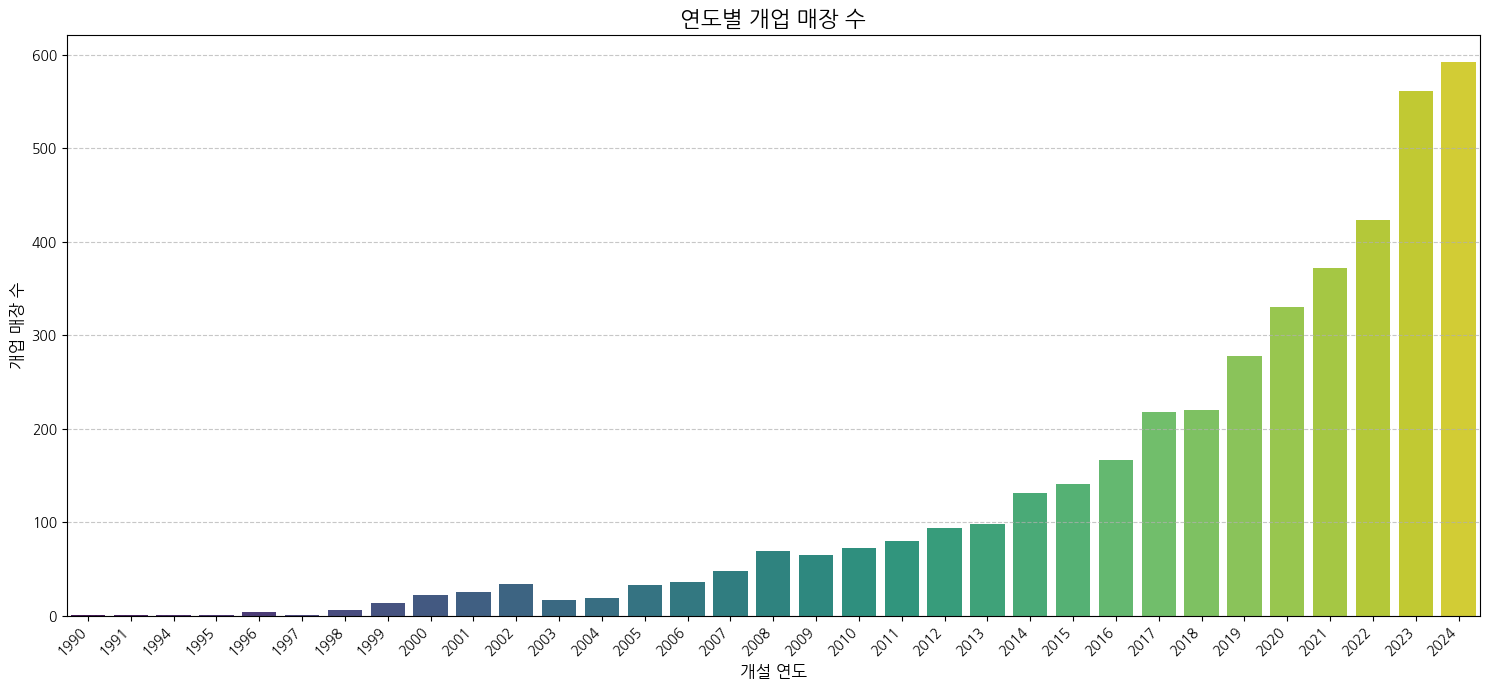

In [ ]:
plt.figure(figsize=(15, 7))
sns.barplot(x=opened_stores_per_year.index, y=opened_stores_per_year.values, palette='viridis')
plt.title('연도별 개업 매장 수', fontsize=16)
plt.xlabel('개설 연도', fontsize=12)
plt.ylabel('개업 매장 수', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 월매출건수_구간과 12개월_업종내_매출_백분위와의 관계

'월매출건수_구간'과 '12개월_업종내_매출_백분위' 간의 상관계수: 0.6657


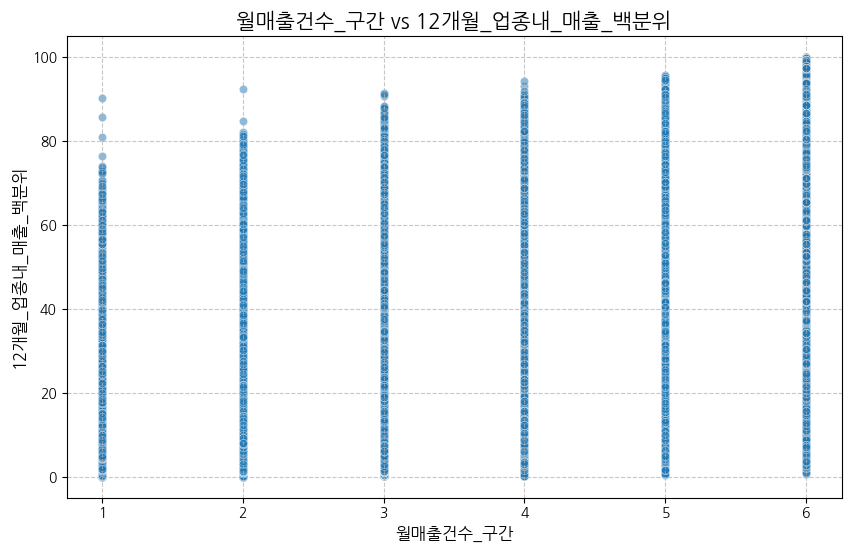

In [ ]:
correlation = df_final['월매출건수_구간'].corr(df_final['12개월_업종내_매출_백분위'])
print(f"'월매출건수_구간'과 '12개월_업종내_매출_백분위' 간의 상관계수: {correlation:.4f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='월매출건수_구간', y='12개월_업종내_매출_백분위', data=df_final, alpha=0.5)
plt.title('월매출건수_구간 vs 12개월_업종내_매출_백분위', fontsize=15)
plt.xlabel('월매출건수_구간', fontsize=12)
plt.ylabel('12개월_업종내_매출_백분위', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
print(df_final[['월매출건수_구간', '12개월_업종내_매출_백분위']].dtypes)
print(df_final[['월매출건수_구간', '12개월_업종내_매출_백분위']].isnull().sum())

월매출건수_구간             int64
12개월_업종내_매출_백분위    float64
dtype: object
월매출건수_구간           0
12개월_업종내_매출_백분위    0
dtype: int64


## 페업여부에 따른 가맹점 재방문 고객 비중 변화

In [ ]:
df_closed_stores = df_final[df_final['폐업여부'] == 1].copy()

print(f"'재방문고객_비중' 컬럼의 결측치 개수 (처리 전): {df_closed_stores['재방문고객_비중'].isnull().sum()}개")
df_closed_stores.dropna(subset=['재방문고객_비중'], inplace=True)
print(f"'재방문고객_비중' 컬럼의 결측치 개수 (처리 후): {df_closed_stores['재방문고객_비중'].isnull().sum()}개")

print(f"'기준년월_dt' 컬럼의 현재 데이터 타입: {df_closed_stores['기준년월_dt'].dtype}")
if not pd.api.types.is_datetime64_any_dtype(df_closed_stores['기준년월_dt']):
    df_closed_stores['기준년월_dt'] = pd.to_datetime(df_closed_stores['기준년월_dt'])
    print(f"'기준년월_dt' 컬럼을 datetime 형식으로 변환 완료. 새 데이터 타입: {df_closed_stores['기준년월_dt'].dtype}")
else:
    print(f"'기준년월_dt' 컬럼은 이미 datetime 형식입니다.")

print(f"필터링 및 결측치 처리 후 df_closed_stores의 행 수: {len(df_closed_stores)}")

'재방문고객_비중' 컬럼의 결측치 개수 (처리 전): 88개
'재방문고객_비중' 컬럼의 결측치 개수 (처리 후): 0개
'기준년월_dt' 컬럼의 현재 데이터 타입: object
'기준년월_dt' 컬럼을 datetime 형식으로 변환 완료. 새 데이터 타입: datetime64[ns]
필터링 및 결측치 처리 후 df_closed_stores의 행 수: 2246


In [ ]:
print(f"max : {df_final['재방문고객_비중'].max()}")
print(f"min : {df_final['재방문고객_비중'].min()}")
print(f"mean : {df_final['재방문고객_비중'].mean()}")

max : 100.0
min : 0.0
mean : 25.327967625686775


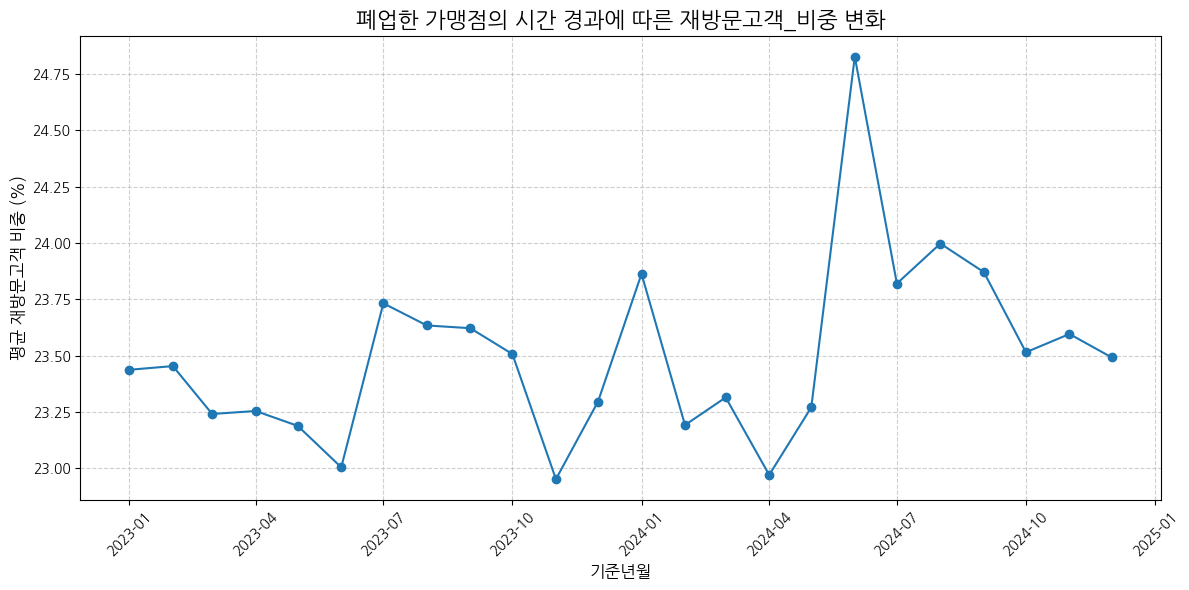

In [ ]:
avg_revisit_ratio_closed = df_closed_stores.groupby('기준년월_dt')['재방문고객_비중'].mean().reset_index()
avg_revisit_ratio_closed = avg_revisit_ratio_closed.sort_values('기준년월_dt')

plt.figure(figsize=(12, 6))
plt.plot(avg_revisit_ratio_closed['기준년월_dt'], avg_revisit_ratio_closed['재방문고객_비중'], marker='o', linestyle='-')
plt.title('폐업한 가맹점의 시간 경과에 따른 재방문고객_비중 변화', fontsize=16)
plt.xlabel('기준년월', fontsize=12)
plt.ylabel('평균 재방문고객 비중 (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 상권 클러스터 분석(개폐업수)_모든 연도

In [ ]:
#연도별 개설일 분석
openings_per_cluster_yearly = df_final_1.groupby(['상권클러스터', '개설연도'])['가맹점구분번호'].nunique().reset_index()
openings_per_cluster_yearly = openings_per_cluster_yearly.rename(columns={'가맹점구분번호': '개업수'})

print("Annual openings per commercial cluster:")
print(openings_per_cluster_yearly.head())

Annual openings per commercial cluster:
   상권클러스터  개설연도  개업수
0       0  1996    2
1       0  1998    1
2       0  2000    3
3       0  2005    5
4       0  2006    2


In [ ]:
#연도별 폐업일 분석
closed_stores = df_final_1[df_final['폐업일'].notna()].copy()
closings_per_cluster_yearly = closed_stores.groupby(['상권클러스터', '폐업연도'])['가맹점구분번호'].nunique().reset_index()
closings_per_cluster_yearly = closings_per_cluster_yearly.rename(columns={'가맹점구분번호': '폐업수'})

print("Annual closings per commercial cluster:")
print(closings_per_cluster_yearly.head())

Annual closings per commercial cluster:
   상권클러스터    폐업연도  폐업수
0       0  2023.0    2
1       0  2025.0    6
2       1  2025.0    9
3       2  2023.0    1
4       2  2024.0    1


In [ ]:
closings_per_cluster_yearly.loc[:, '폐업연도'] = closings_per_cluster_yearly['폐업연도'].astype(int)

print("Data type of '폐업연도' after conversion:")
print(closings_per_cluster_yearly['폐업연도'].dtype)

Data type of '폐업연도' after conversion:
float64


In [ ]:
cluster_trends = pd.merge(
    openings_per_cluster_yearly, closings_per_cluster_yearly,
    left_on=['상권클러스터', '개설연도'], right_on=['상권클러스터', '폐업연도'],
    how='outer'
)

# Rename the year column to a common name
cluster_trends.rename(columns={'개설연도': '연도', '폐업연도': '연도'}, inplace=True)

# Fill NaN values for openings and closings with 0
cluster_trends['개업수'] = cluster_trends['개업수'].fillna(0)
cluster_trends['폐업수'] = cluster_trends['폐업수'].fillna(0)

# Calculate net change
cluster_trends['순변화'] = cluster_trends['개업수'] - cluster_trends['폐업수']

# Calculate stability metrics
stability_metrics = cluster_trends.groupby('상권클러스터').agg(
    순변화_표준편차=('순변화', 'std'),
    총_개업수=('개업수', 'sum'),
    총_폐업수=('폐업수', 'sum')
).reset_index()

# Calculate opening to closing ratio, handling division by zero
stability_metrics['개업_폐업_비율'] = stability_metrics['총_개업수'] / stability_metrics['총_폐업수']
stability_metrics['개업_폐업_비율'] = stability_metrics['개업_폐업_비율'].replace([np.inf, -np.inf], np.nan).fillna(0) # Replace inf with nan, then nan with 0 for cases where 총_폐업수 is 0

print("\nCluster Trends DataFrame Head:")
print(cluster_trends.head())
print("\nStability Metrics DataFrame Head:")
print(stability_metrics.head())


Cluster Trends DataFrame Head:
   상권클러스터      연도  개업수  연도  폐업수  순변화
0       0  1996.0  2.0 NaN  0.0  2.0
1       0  1998.0  1.0 NaN  0.0  1.0
2       0  2000.0  3.0 NaN  0.0  3.0
3       0  2005.0  5.0 NaN  0.0  5.0
4       0  2006.0  2.0 NaN  0.0  2.0

Stability Metrics DataFrame Head:
   상권클러스터   순변화_표준편차  총_개업수  총_폐업수   개업_폐업_비율
0       0   9.777877  231.0    8.0  28.875000
1       1   9.948299  232.0    9.0  25.777778
2       2  18.717955  391.0   17.0  23.000000
3       3  10.876672  389.0    9.0  43.222222
4       4  12.117422  315.0   10.0  31.500000


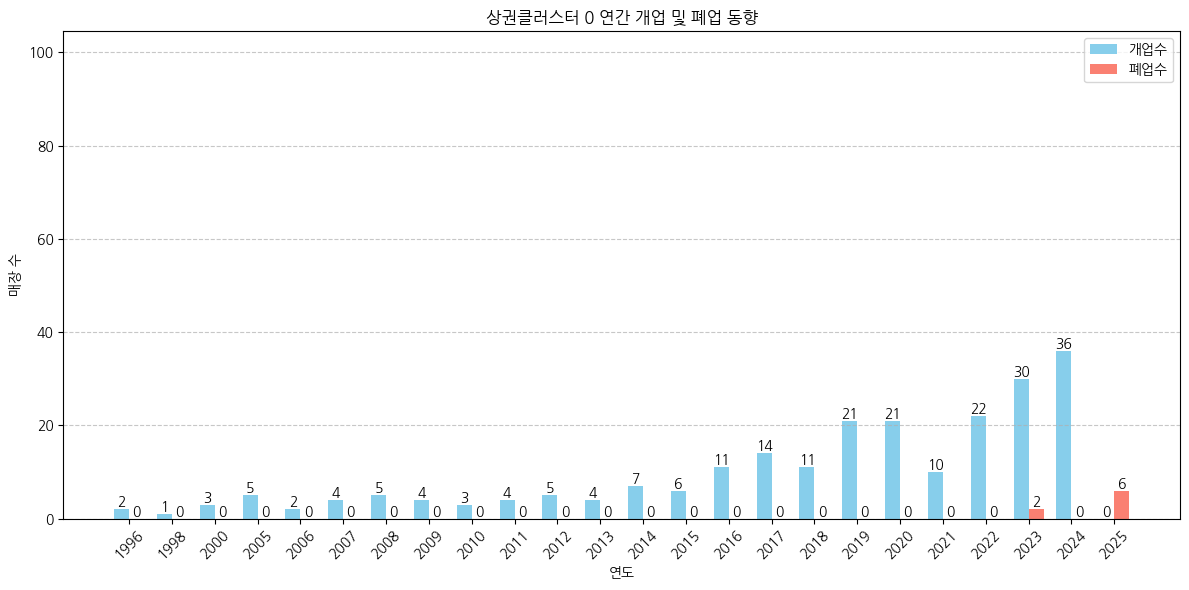

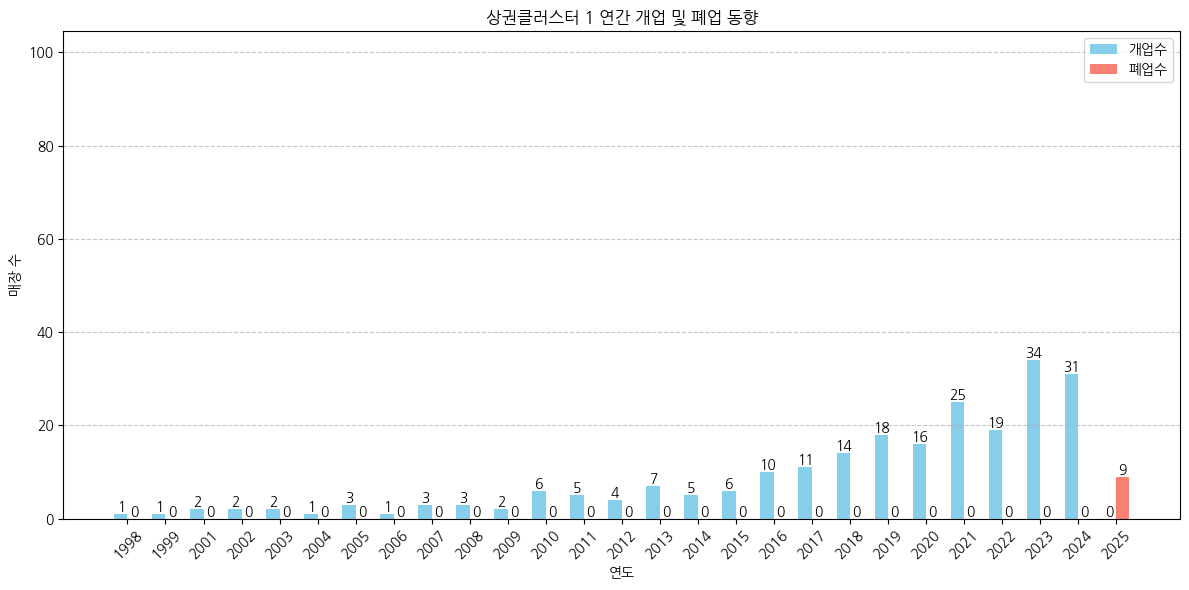

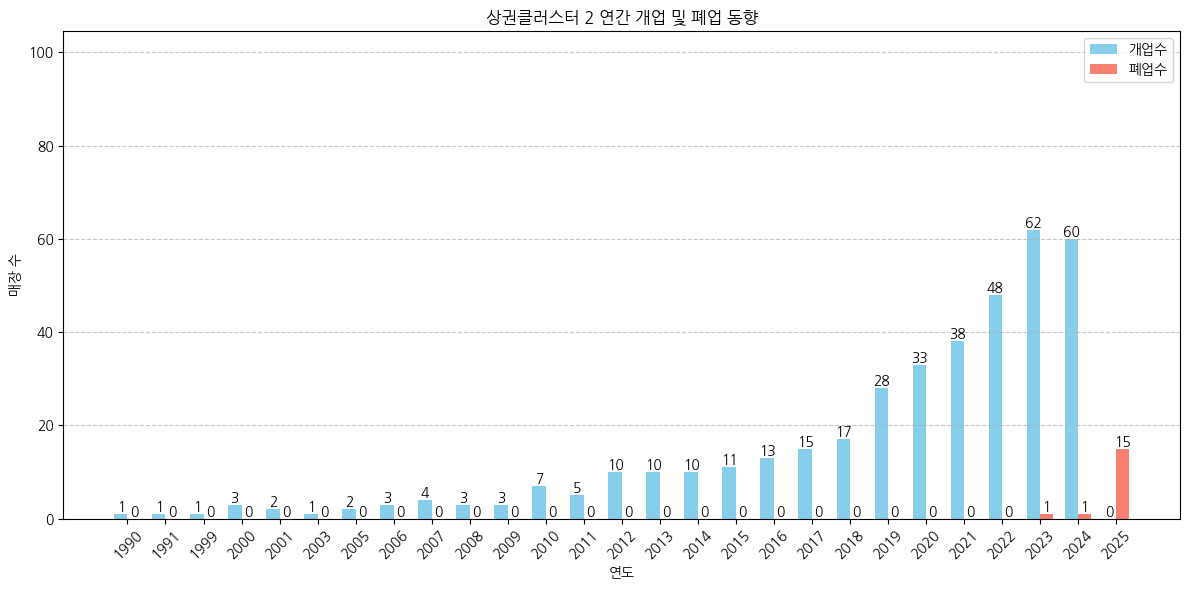

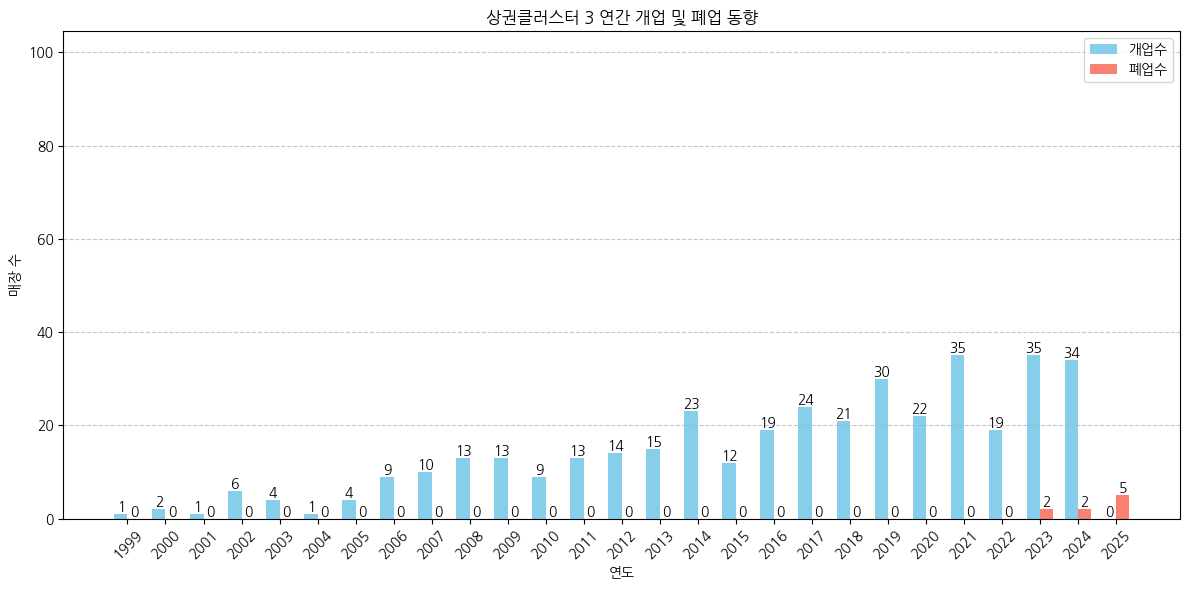

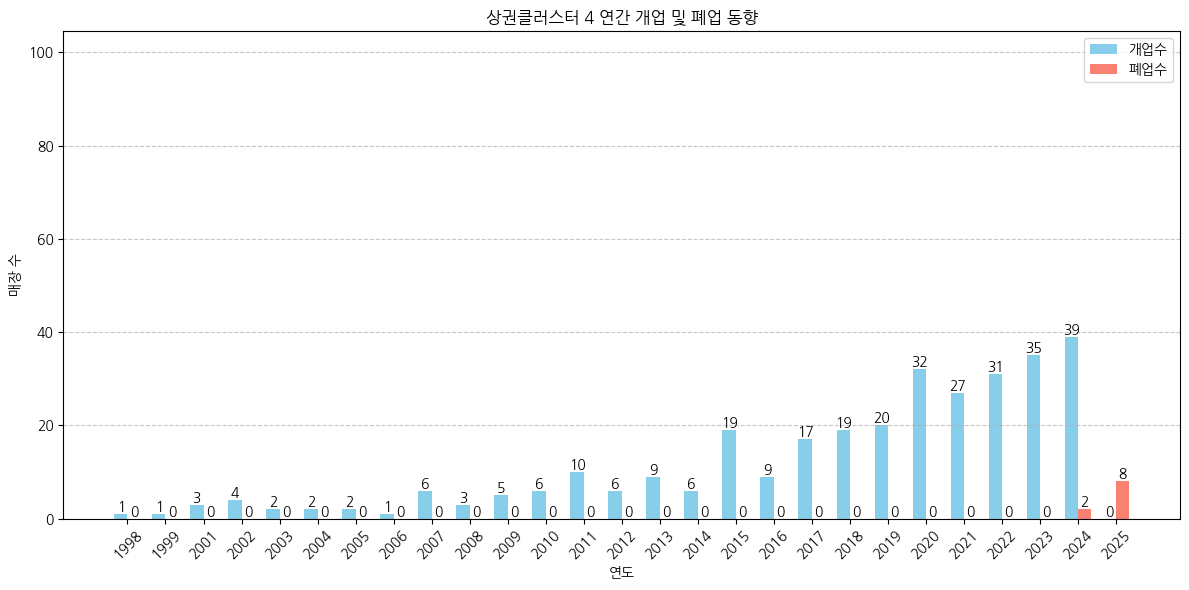

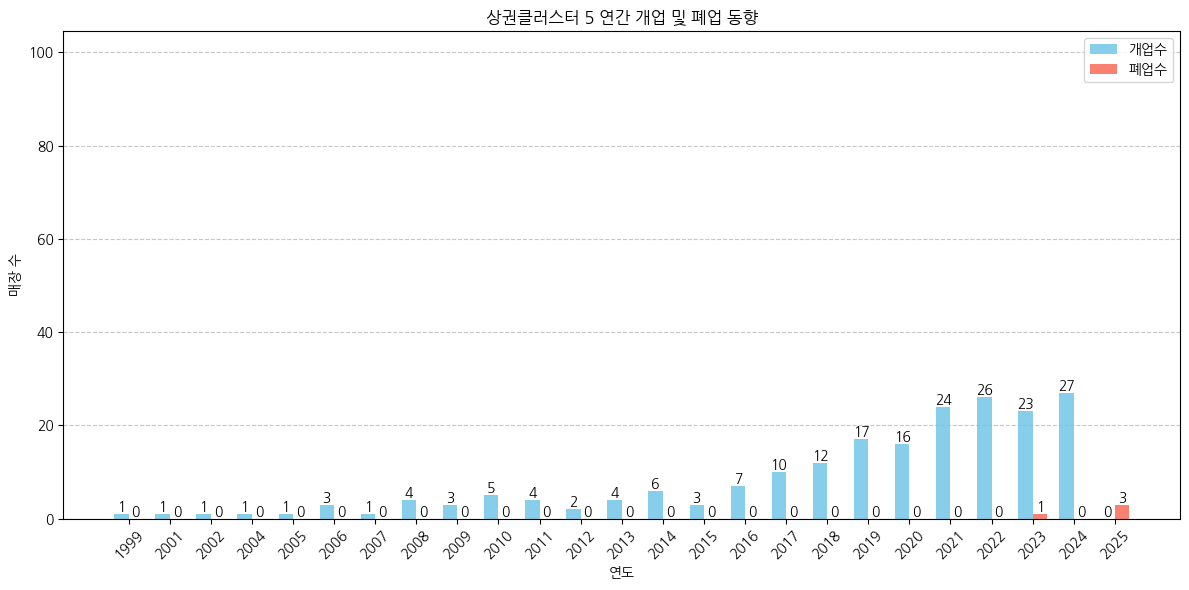

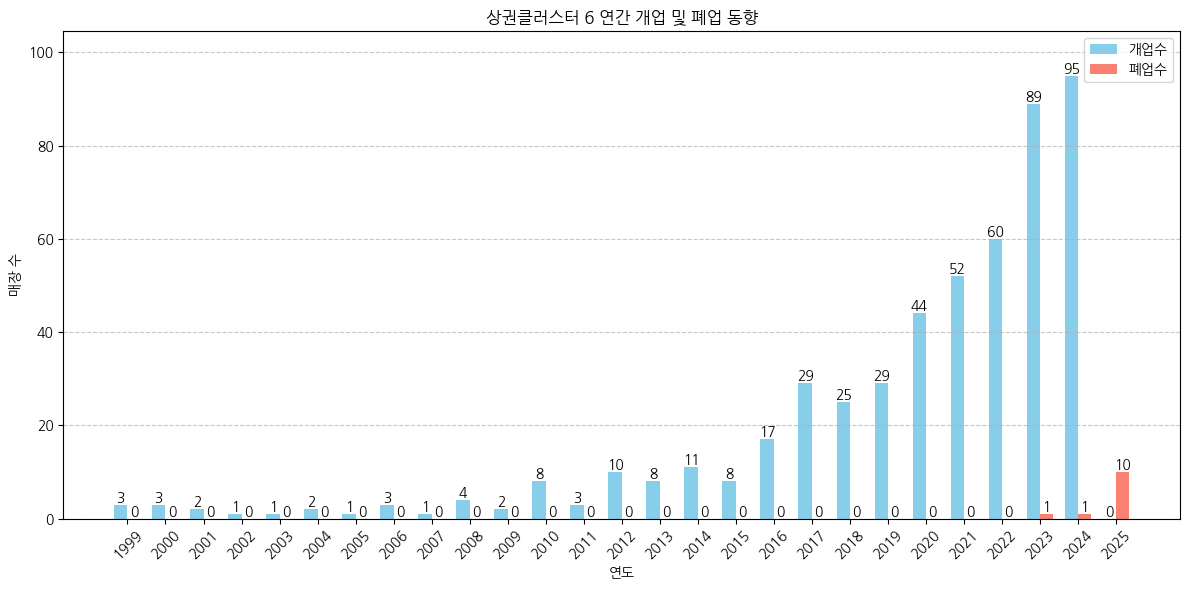

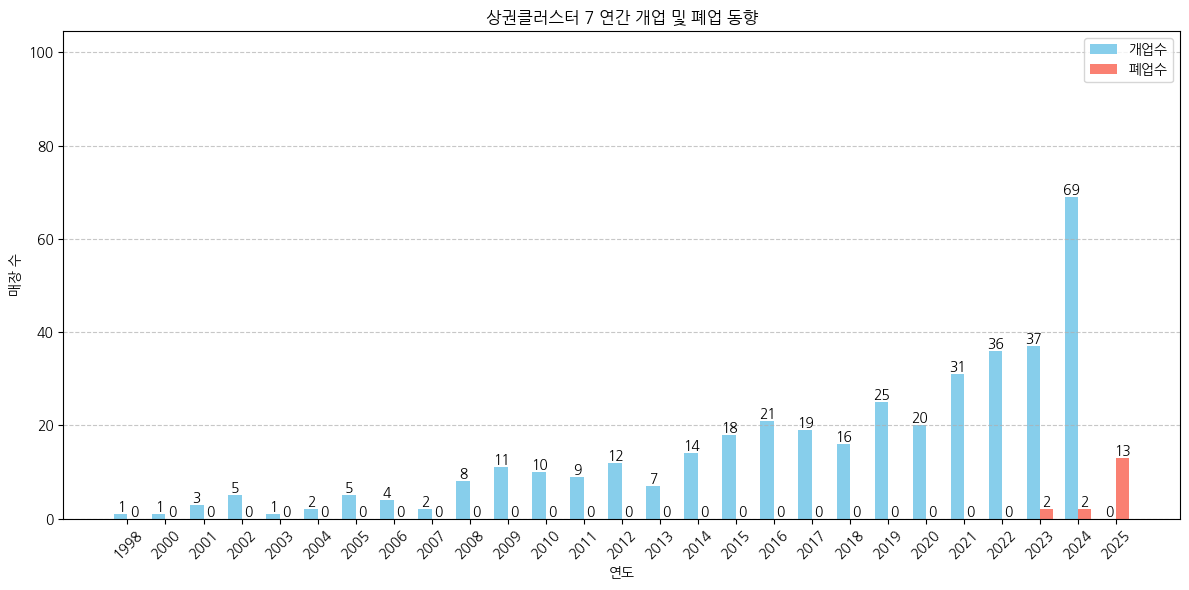

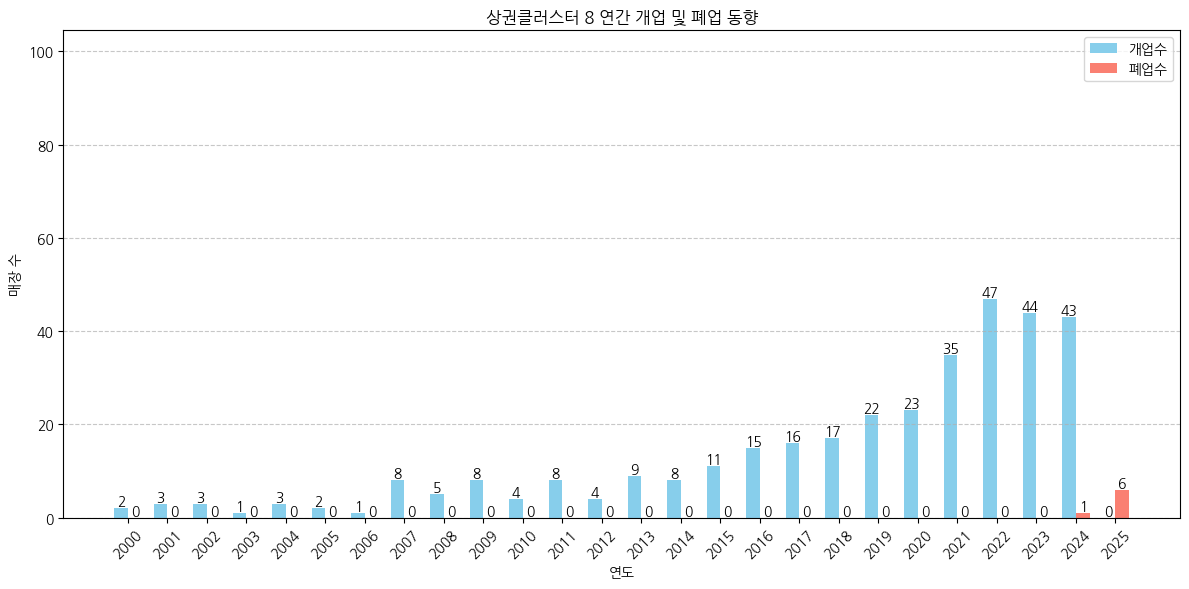

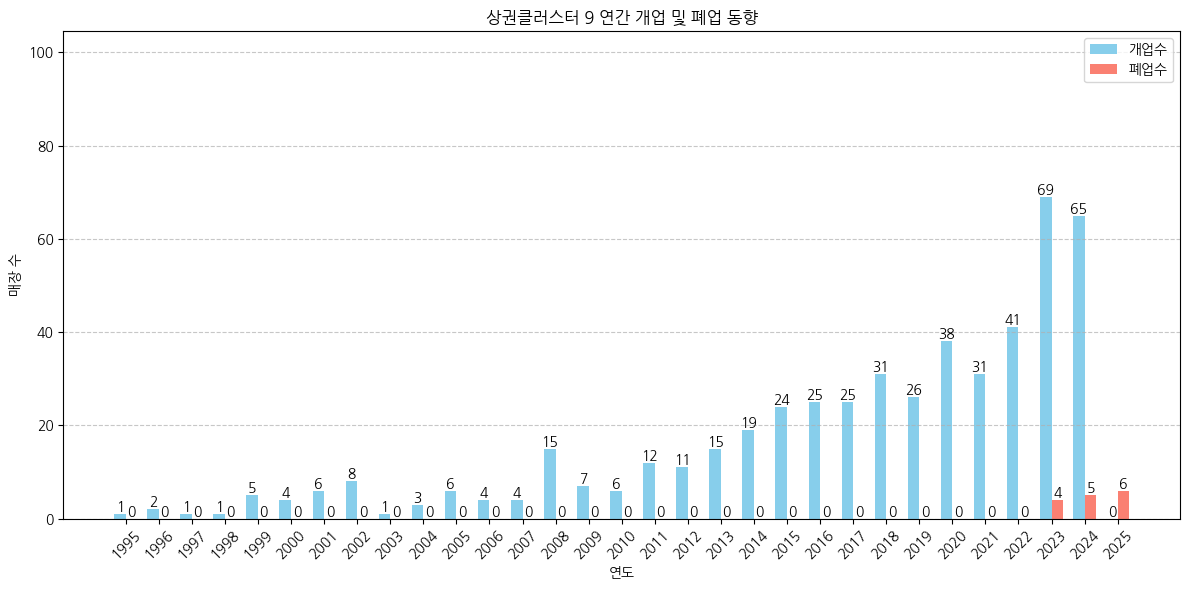

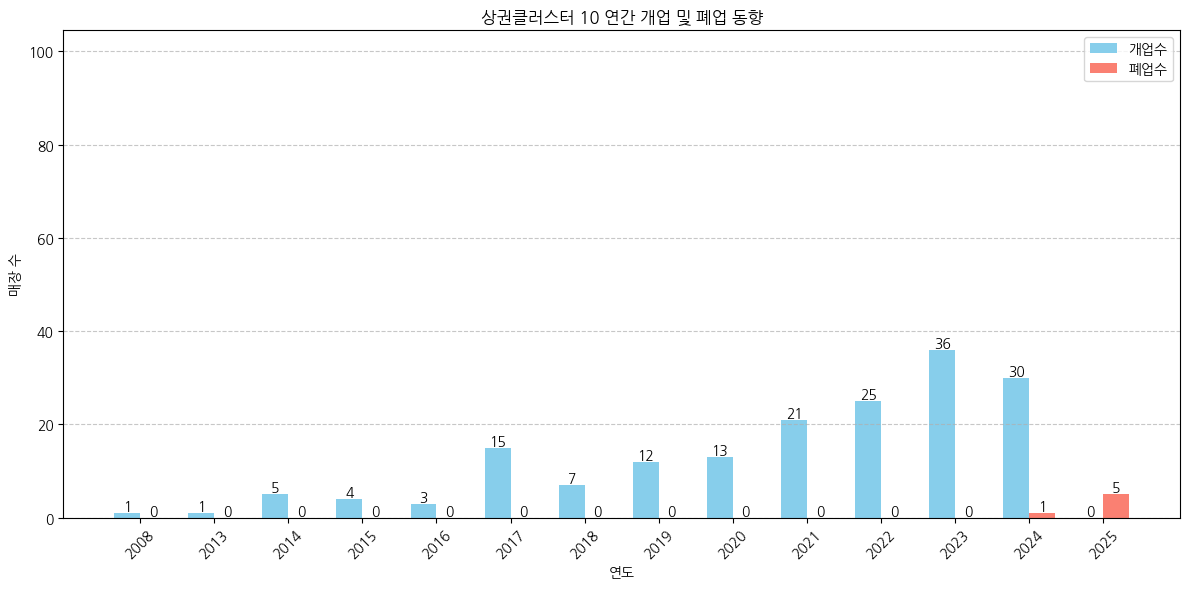

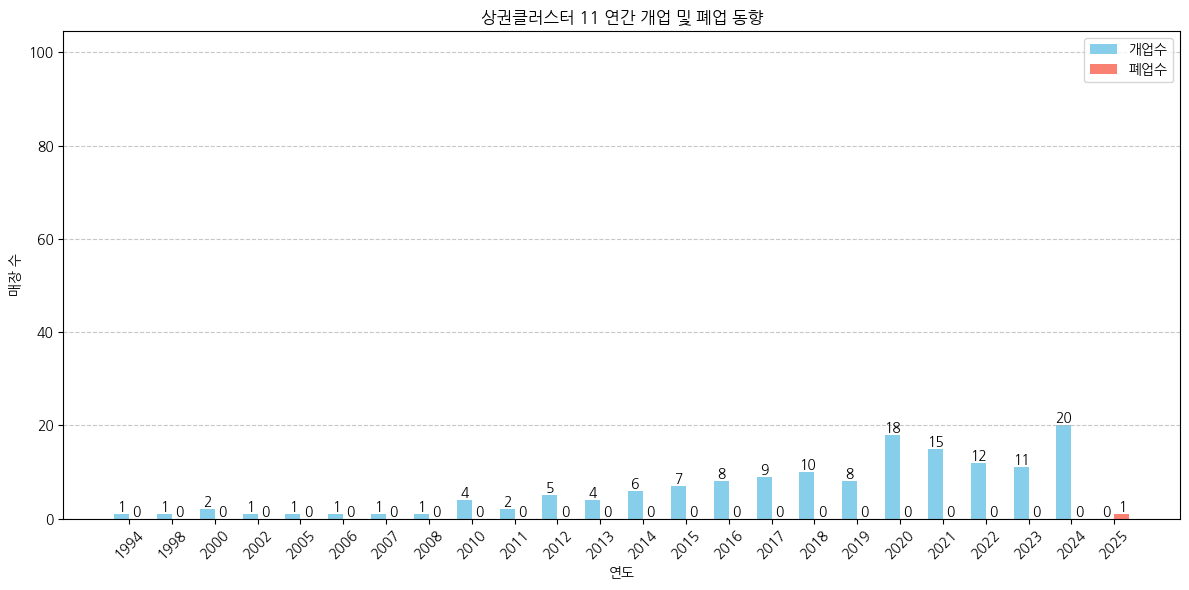

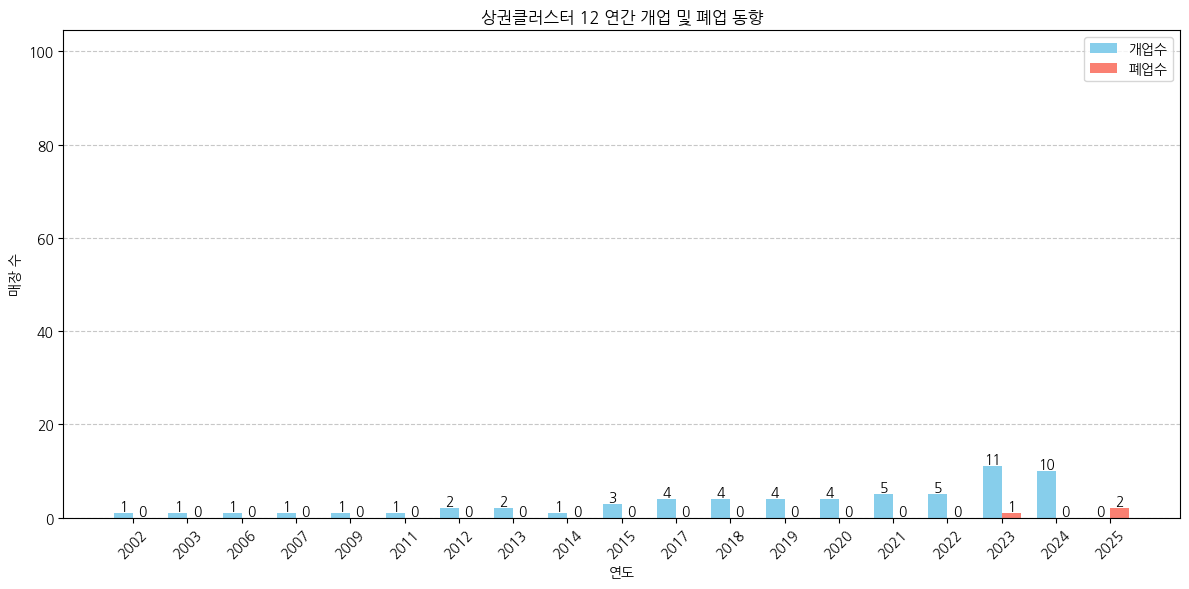

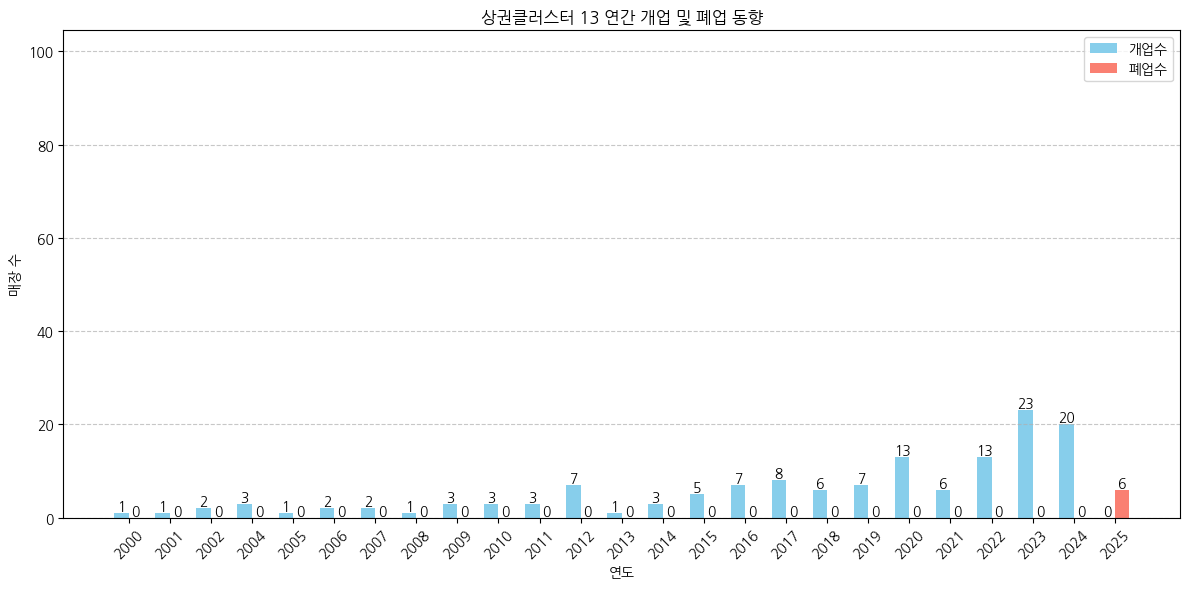

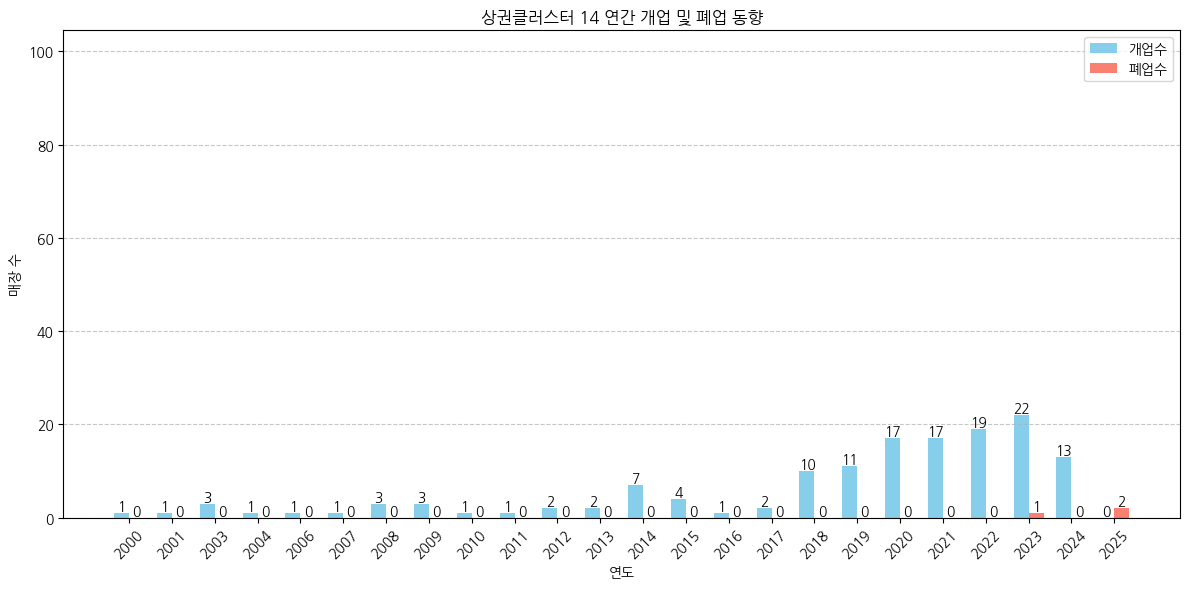

In [ ]:
# Determine the global maximum value for y-axis across all clusters for openings and closings
global_max_count = max(cluster_trends['개업수'].max(), cluster_trends['폐업수'].max())
y_max_limit = global_max_count * 1.1 # Add 10% padding

unique_clusters = cluster_trends['상권클러스터'].unique()

for cluster_id in unique_clusters:
    cluster_data = cluster_trends[cluster_trends['상권클러스터'] == cluster_id].sort_values('연도')

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.35
    index = np.arange(len(cluster_data['연도']))

    # Plot openings and closings as grouped bars
    bar1_pos = index - bar_width/2
    bar2_pos = index + bar_width/2

    p1 = ax.bar(bar1_pos, cluster_data['개업수'], bar_width, label='개업수', color='skyblue')
    p2 = ax.bar(bar2_pos, cluster_data['폐업수'], bar_width, label='폐업수', color='salmon')

    # Add text labels on top of each bar
    for bar in p1:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height), ha='center', va='bottom')
    for bar in p2:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height), ha='center', va='bottom')

    ax.set_xlabel('연도')
    ax.set_ylabel('매장 수')
    ax.set_title(f'상권클러스터 {int(cluster_id)} 연간 개업 및 폐업 동향')
    ax.set_xticks(index)
    ax.set_xticklabels(cluster_data['연도'].astype(int), rotation=45)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Set consistent y-axis limit
    ax.set_ylim(0, y_max_limit)

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-360697500.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='상권클러스터', y='개업_폐업_비율', data=ratio_sorted, palette='viridis')


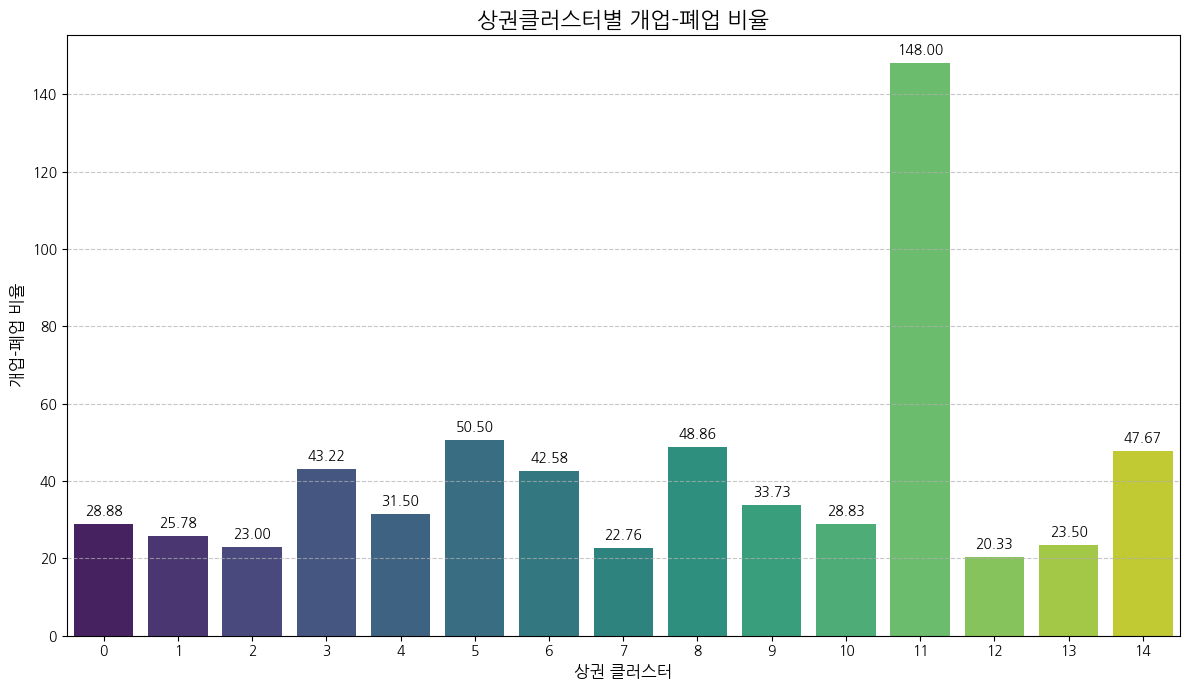

In [ ]:
# 개업_폐업_비율을 기준으로 상권 클러스터 정렬
ratio_sorted = stability_metrics.sort_values(by='개업_폐업_비율', ascending=False)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='상권클러스터', y='개업_폐업_비율', data=ratio_sorted, palette='viridis')

# 각 막대 위에 값 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title('상권클러스터별 개업-폐업 비율', fontsize=16)
plt.xlabel('상권 클러스터', fontsize=12)
plt.ylabel('개업-폐업 비율', fontsize=12)
plt.xticks(rotation=0) # 클러스터 ID가 많지 않으므로 회전 불필요
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 상권 클러스터 분석(순변화)_모든 연도

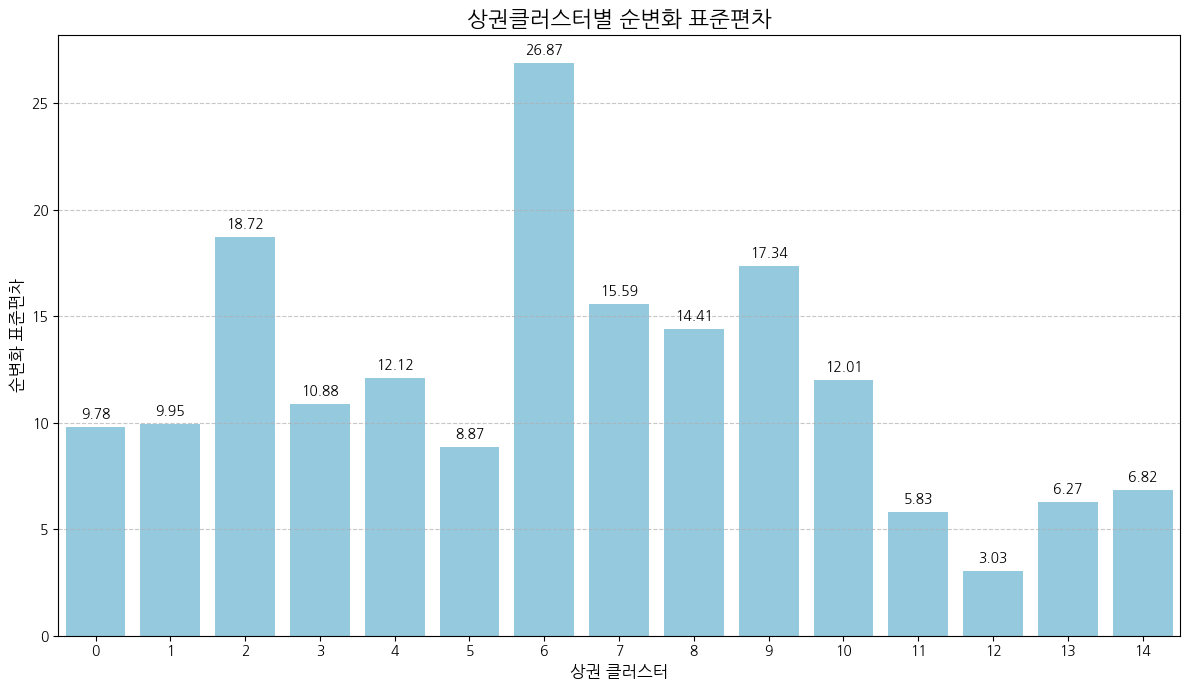

In [ ]:
# 순변화 표준편차를 기준으로 상권 클러스터 정렬
std_dev_sorted = stability_metrics.sort_values(by='순변화_표준편차', ascending=False)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='상권클러스터', y='순변화_표준편차', data=std_dev_sorted,  color='skyblue')

# 각 막대 위에 값 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title('상권클러스터별 순변화 표준편차', fontsize=16)
plt.xlabel('상권 클러스터', fontsize=12)
plt.ylabel('순변화 표준편차', fontsize=12)
plt.xticks(rotation=0) # 클러스터 ID가 많지 않으므로 회전 불필요
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1351004209.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='상권클러스터', y='순변화_표준편차', data=std_dev_sorted_again, palette='coolwarm', order=std_dev_sorted_again['상권클러스터'])


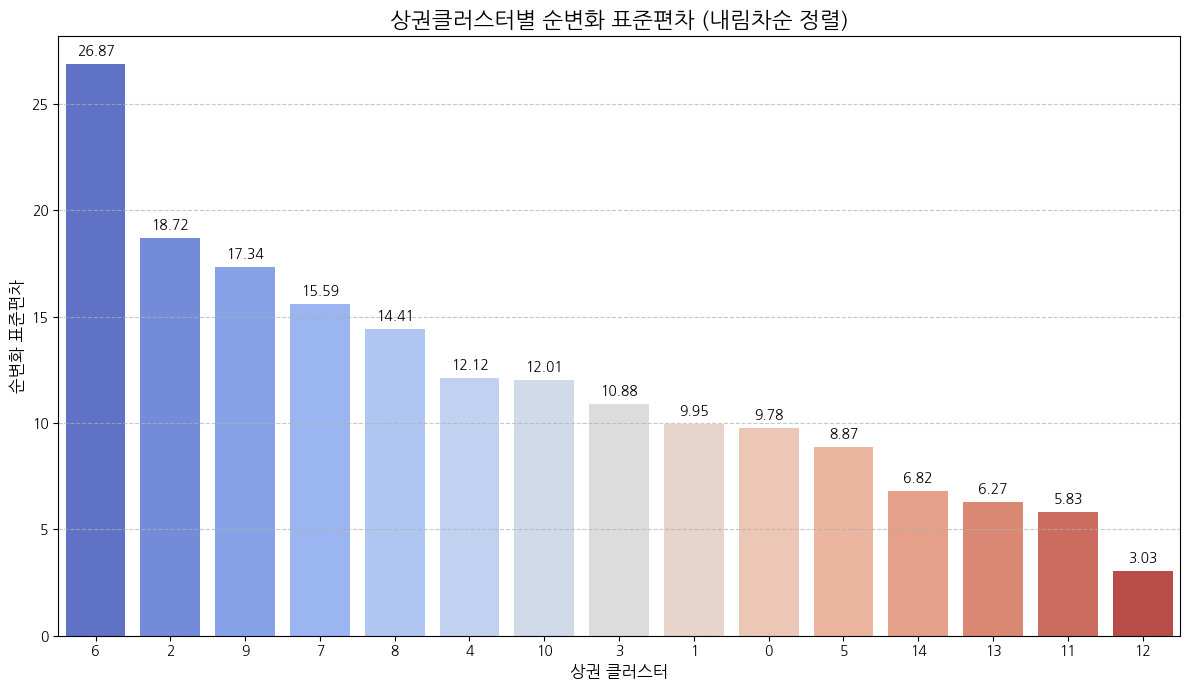

In [ ]:
# 순변화 표준편차를 기준으로 상권 클러스터 정렬 (내림차순)
std_dev_sorted_again = stability_metrics.sort_values(by='순변화_표준편차', ascending=False)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='상권클러스터', y='순변화_표준편차', data=std_dev_sorted_again, palette='coolwarm', order=std_dev_sorted_again['상권클러스터'])

# 각 막대 위에 값 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title('상권클러스터별 순변화 표준편차 (내림차순 정렬)', fontsize=16)
plt.xlabel('상권 클러스터', fontsize=12)
plt.ylabel('순변화 표준편차', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 상권클러스터 분석(개폐업수)_23-24년
- 월별로 분석 진행

In [ ]:
df_final_1.loc[:, '기준년월_dt'] = pd.to_datetime(df_final_1['기준년월_dt'])

start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2024-12-01')

df_filtered_period = df_final_1[(df_final_1['기준년월_dt'] >= start_date) & (df_final_1['기준년월_dt'] <= end_date)].copy()

print("df_filtered_period head:")
print(df_filtered_period.head())
print("\ndf_filtered_period shape:")
print(df_filtered_period.shape)

df_filtered_period head:
      가맹점구분번호  운영개월수_구간  월매출_구간  월매출건수_구간  월고객수_구간  객단가_구간  배달매출비율  \
0  000F03E44A         5       6         5        5       4     NaN   
1  000F03E44A         5       6         6        6       6     NaN   
2  000F03E44A         5       6         6        6       6     NaN   
3  000F03E44A         5       6         5        5       3     NaN   
4  000F03E44A         5       6         5        5       6     NaN   

   12개월_업종대비_평균매출_비율  12개월_업종대비_평균매출건수_비율  12개월_업종내_매출_백분위  \
0                0.5                  1.1             95.3   
1                0.0                  0.0             95.2   
2                0.0                  0.0             95.0   
3                1.3                  1.0             94.5   
4                0.0                  1.0             94.6   

   12개월_동일업종_폐업가맹점_비중  12개월_동일상권_폐업가맹점_비중  재방문고객_비중  신규고객_비중  거주지고객_비중  \
0                15.8                 7.9       0.0   100.00       0.0   
1                16.3            

In [ ]:
df_filtered_period['기준년월_dt'] = pd.to_datetime(df_filtered_period['기준년월_dt'], errors='coerce')
df_filtered_period['개설일'] = pd.to_datetime(df_filtered_period['개설일'], errors='coerce')
df_filtered_period['폐업일'] = pd.to_datetime(df_filtered_period['폐업일'], errors='coerce')

# Print dtypes to confirm conversion
print("Dtypes after conversion:")
print(df_filtered_period[['기준년월_dt', '개설일', '폐업일']].dtypes)

df_filtered_period.loc[:, '연도'] = df_filtered_period['기준년월_dt'].dt.year
df_filtered_period.loc[:, '월'] = df_filtered_period['기준년월_dt'].dt.month

# Calculate monthly openings
monthly_openings = df_filtered_period[
    (df_filtered_period['개설일'].dt.year == df_filtered_period['연도']) &
    (df_filtered_period['개설일'].dt.month == df_filtered_period['월']) &
    (df_filtered_period['개설일'].notna())
].groupby(['상권클러스터', '연도', '월'])['가맹점구분번호'].nunique().reset_index()
monthly_openings = monthly_openings.rename(columns={'가맹점구분번호': '월별_개업수'})

# Calculate monthly closings
monthly_closings = df_filtered_period[
    (df_filtered_period['폐업일'].dt.year == df_filtered_period['연도']) &
    (df_filtered_period['폐업일'].dt.month == df_filtered_period['월']) &
    (df_filtered_period['폐업일'].notna())
].groupby(['상권클러스터', '연도', '월'])['가맹점구분번호'].nunique().reset_index()
monthly_closings = monthly_closings.rename(columns={'가맹점구분번호': '월별_폐업수'})

print("Monthly Openings (first 5 rows):")
print(monthly_openings.head())
print("\nMonthly Closings (first 5 rows):")
print(monthly_closings.head())

print(f"\nShape of monthly_openings: {monthly_openings.shape}")
print(f"Shape of monthly_closings: {monthly_closings.shape}")

Dtypes after conversion:
기준년월_dt    datetime64[ns]
개설일        datetime64[ns]
폐업일        datetime64[ns]
dtype: object
Monthly Openings (first 5 rows):
   상권클러스터    연도  월  월별_개업수
0       0  2023  1       2
1       0  2023  2       3
2       0  2023  3       2
3       0  2023  4       3
4       0  2023  5       4

Monthly Closings (first 5 rows):
   상권클러스터    연도   월  월별_폐업수
0       0  2023   5       1
1       0  2023  11       1
2       2  2023   4       1
3       2  2024   1       1
4       3  2023   8       1

Shape of monthly_openings: (318, 4)
Shape of monthly_closings: (28, 4)


In [ ]:
monthly_trends = pd.merge(
    monthly_openings, monthly_closings,
    on=['상권클러스터', '연도', '월'],
    how='outer'
)

# Fill NaN values for openings and closings with 0
monthly_trends['월별_개업수'] = monthly_trends['월별_개업수'].fillna(0)
monthly_trends['월별_폐업수'] = monthly_trends['월별_폐업수'].fillna(0)

# Calculate monthly net change
monthly_trends['월별_순변화'] = monthly_trends['월별_개업수'] - monthly_trends['월별_폐업수']

# Calculate stability metrics per cluster based on monthly data
monthly_stability_metrics = monthly_trends.groupby('상권클러스터').agg(
    월별_순변화_표준편차=('월별_순변화', 'std'),
    총_월별_개업수=('월별_개업수', 'sum'),
    총_월별_폐업수=('월별_폐업수', 'sum')
).reset_index()

# Calculate monthly opening to closing ratio, handling division by zero
monthly_stability_metrics['월별_개업_폐업_비율'] = monthly_stability_metrics['총_월별_개업수'] / monthly_stability_metrics['총_월별_폐업수']
monthly_stability_metrics['월별_개업_폐업_비율'] = monthly_stability_metrics['월별_개업_폐업_비율'].replace([np.inf, -np.inf], np.nan).fillna(0)

print("Monthly Trends DataFrame Head:")
print(monthly_trends.head())
print("\nMonthly Stability Metrics DataFrame Head:")
print(monthly_stability_metrics.head())

print(f"\nShape of monthly_trends: {monthly_trends.shape}")
print(f"Shape of monthly_stability_metrics: {monthly_stability_metrics.shape}")

Monthly Trends DataFrame Head:
   상권클러스터    연도  월  월별_개업수  월별_폐업수  월별_순변화
0       0  2023  1       2     0.0     2.0
1       0  2023  2       3     0.0     3.0
2       0  2023  3       2     0.0     2.0
3       0  2023  4       3     0.0     3.0
4       0  2023  5       4     1.0     3.0

Monthly Stability Metrics DataFrame Head:
   상권클러스터  월별_순변화_표준편차  총_월별_개업수  총_월별_폐업수  월별_개업_폐업_비율
0       0     1.949581        66       2.0        33.00
1       1     1.230380        65       0.0         0.00
2       2     2.021622       122       2.0        61.00
3       3     2.034869        69       4.0        17.25
4       4     1.906925        74       2.0        37.00

Shape of monthly_trends: (318, 6)
Shape of monthly_stability_metrics: (15, 5)


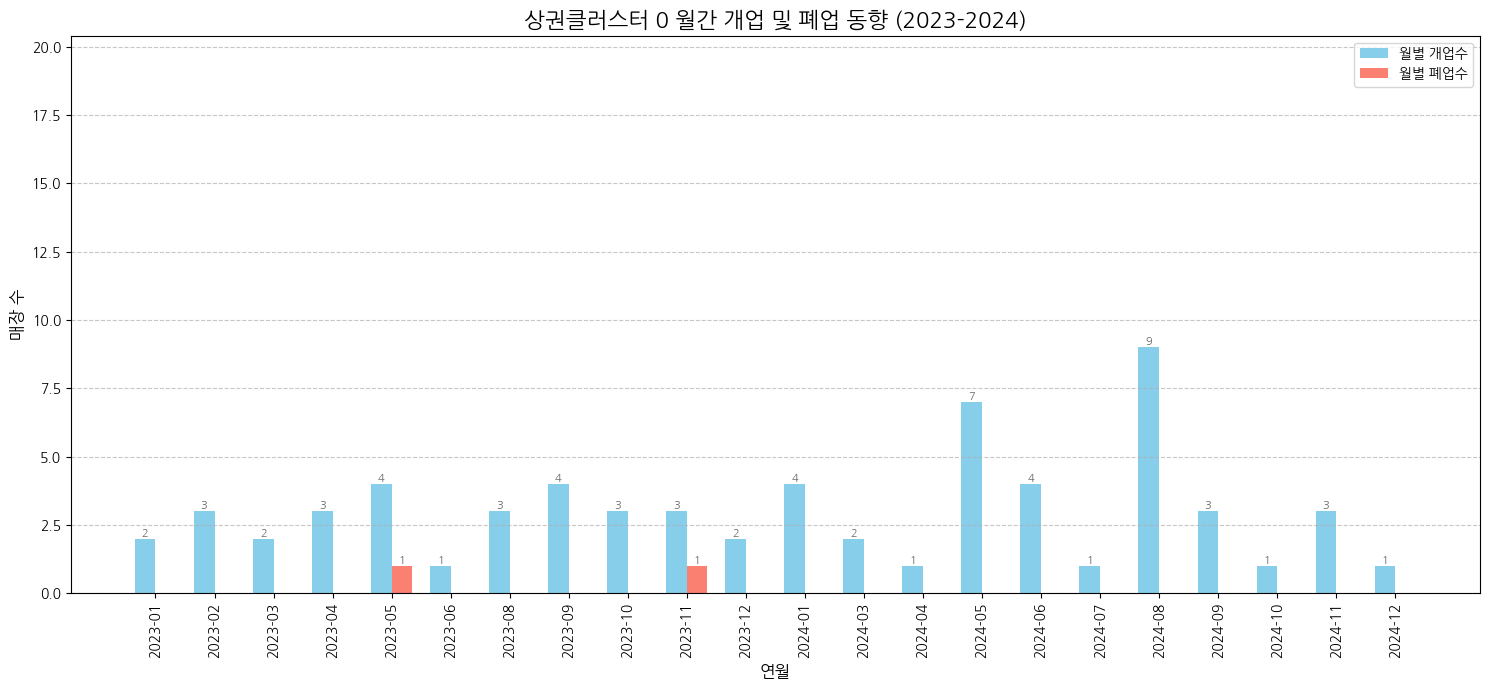

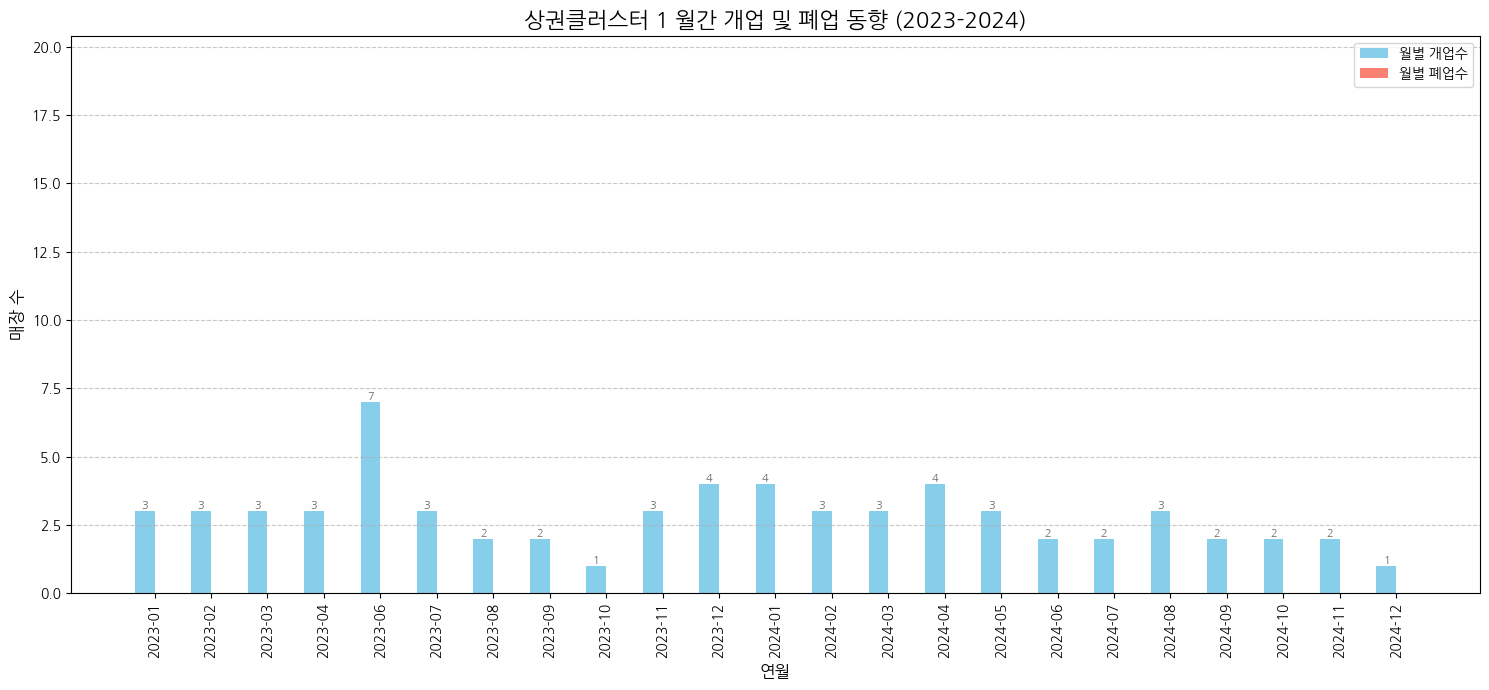

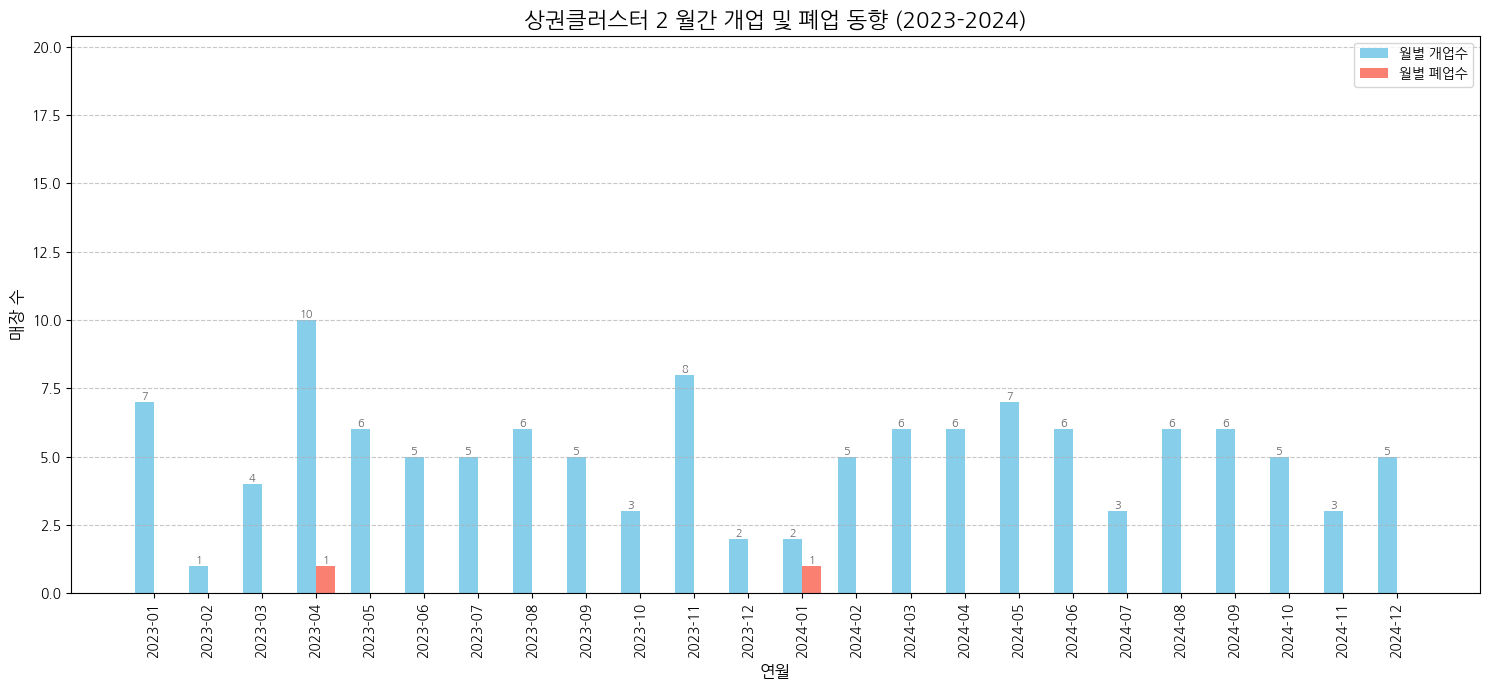

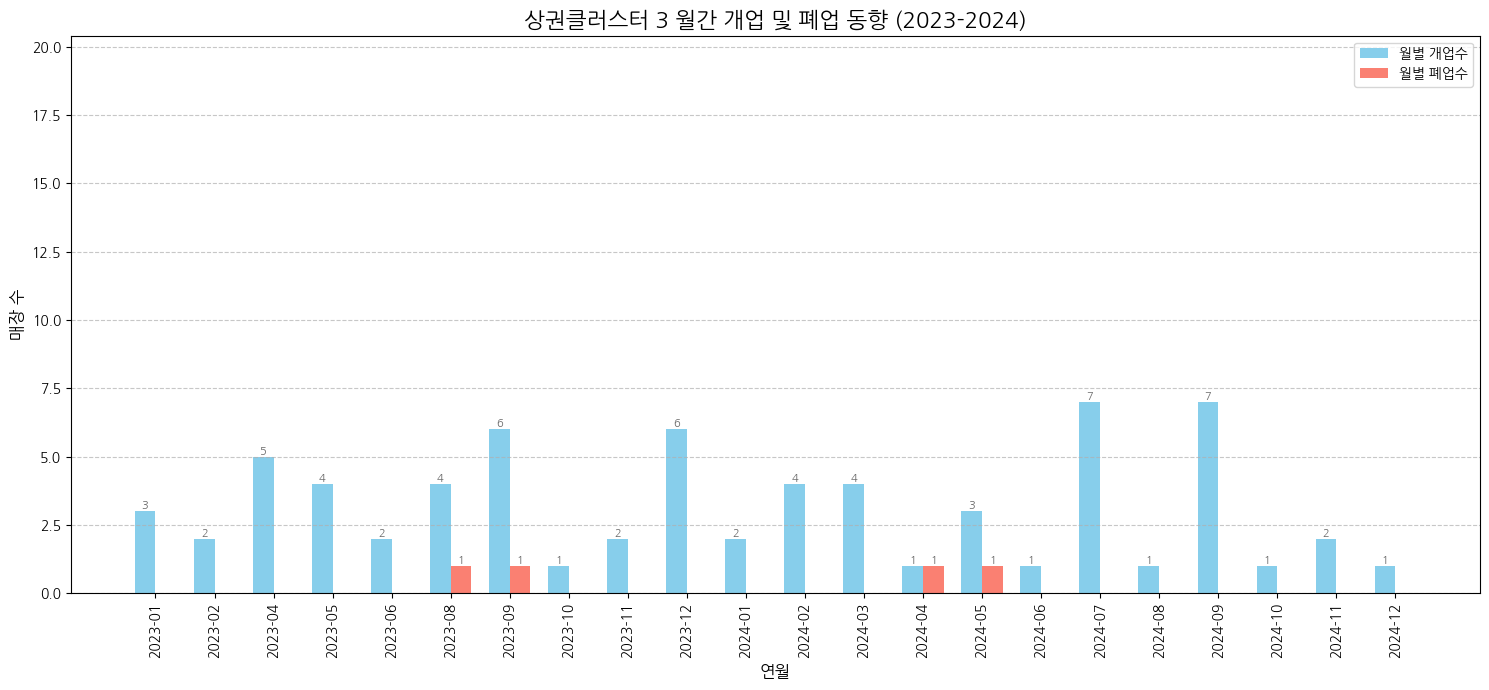

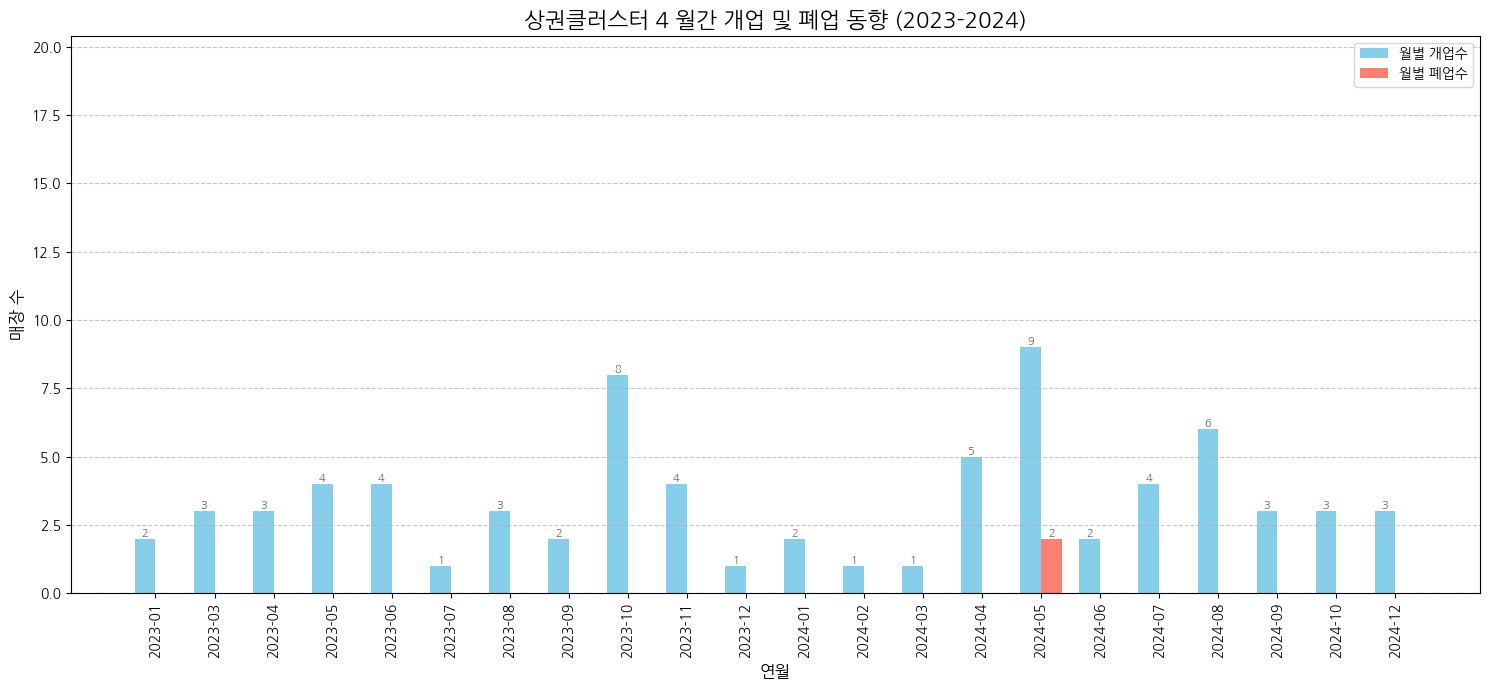

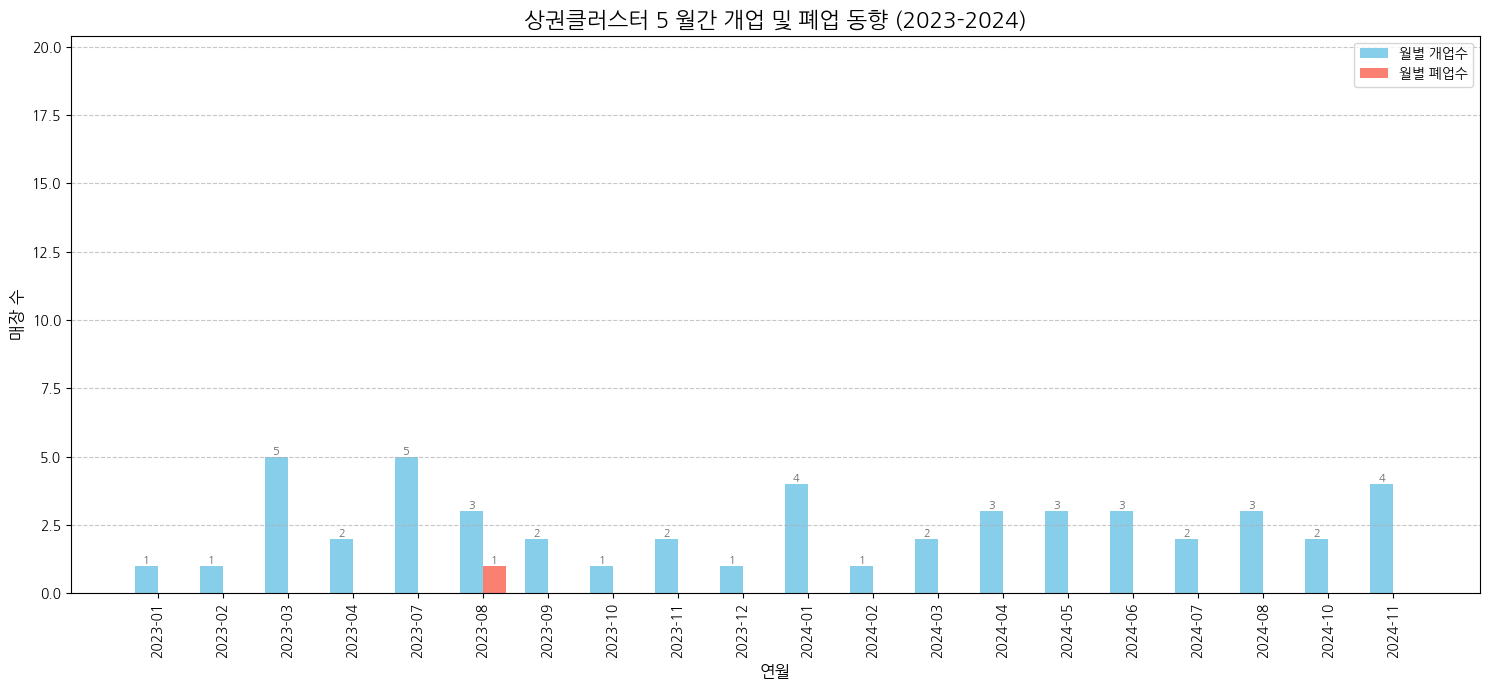

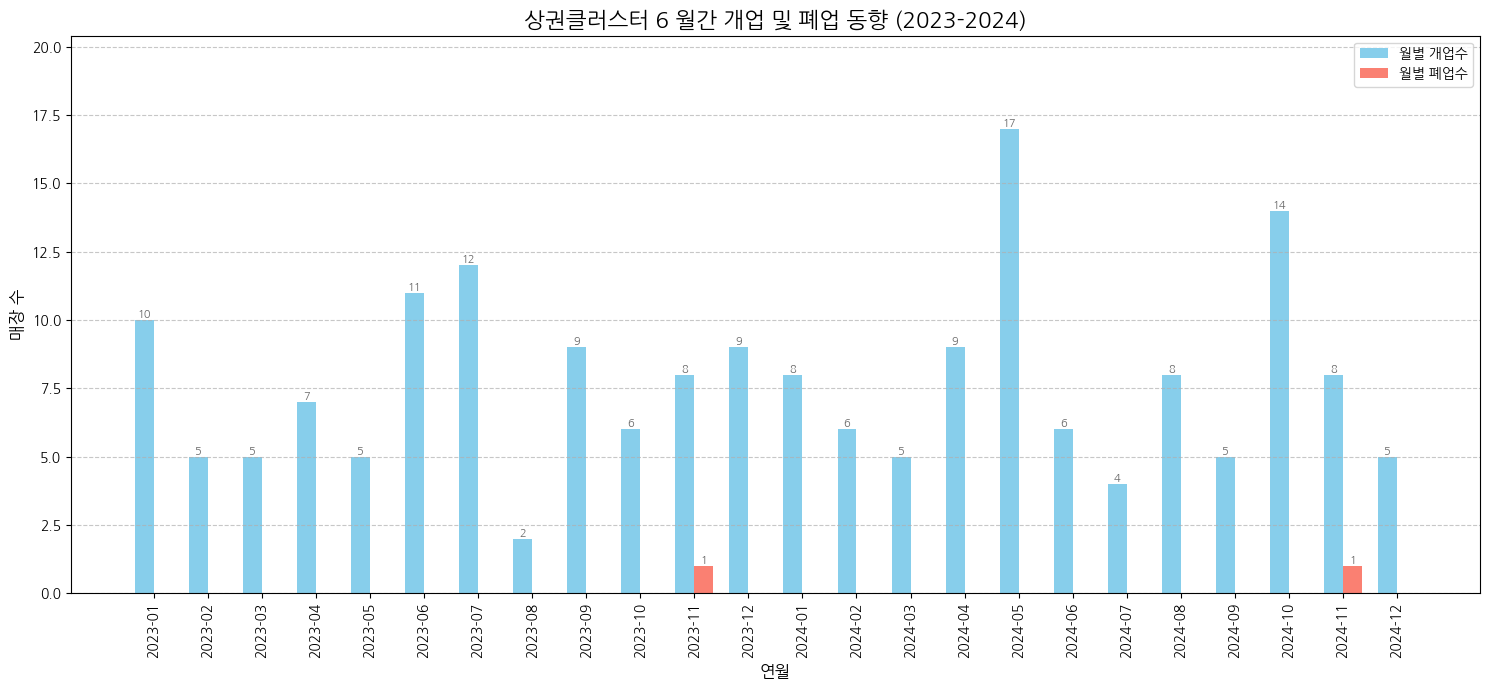

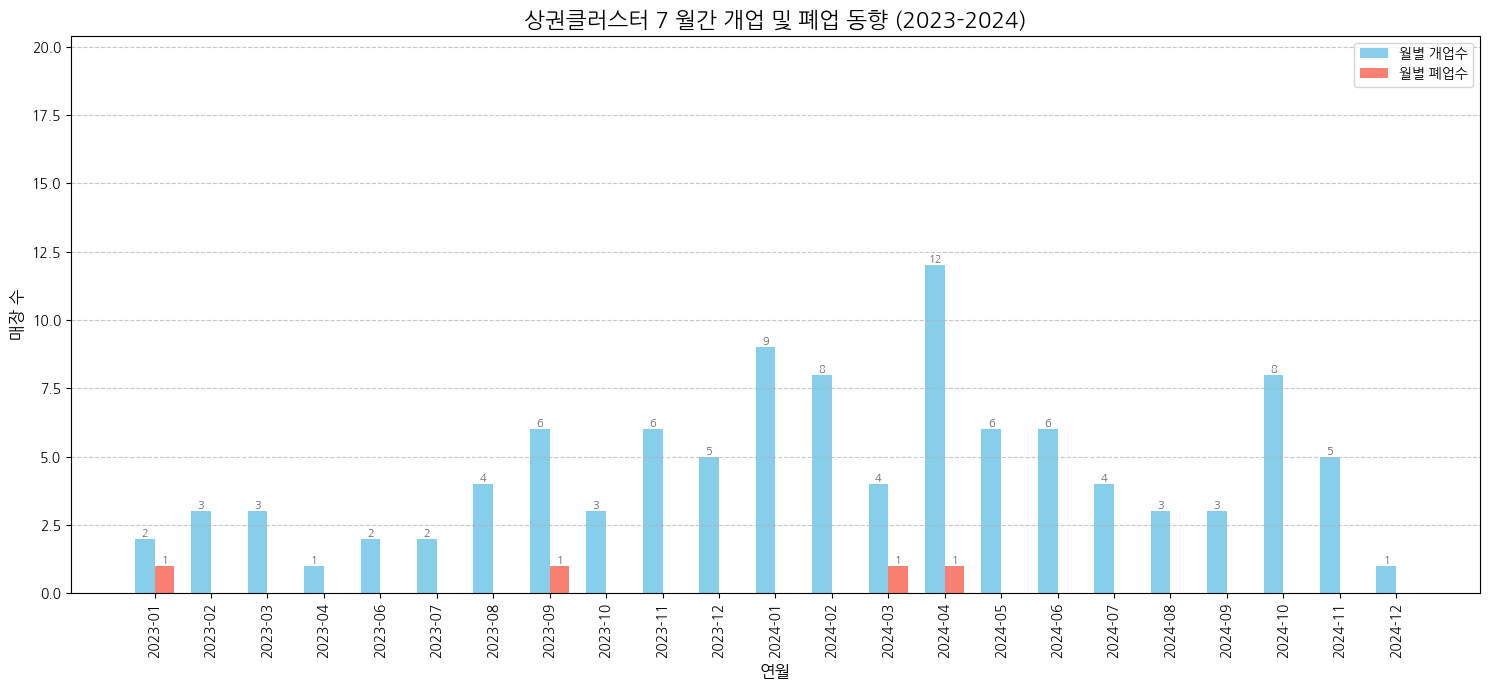

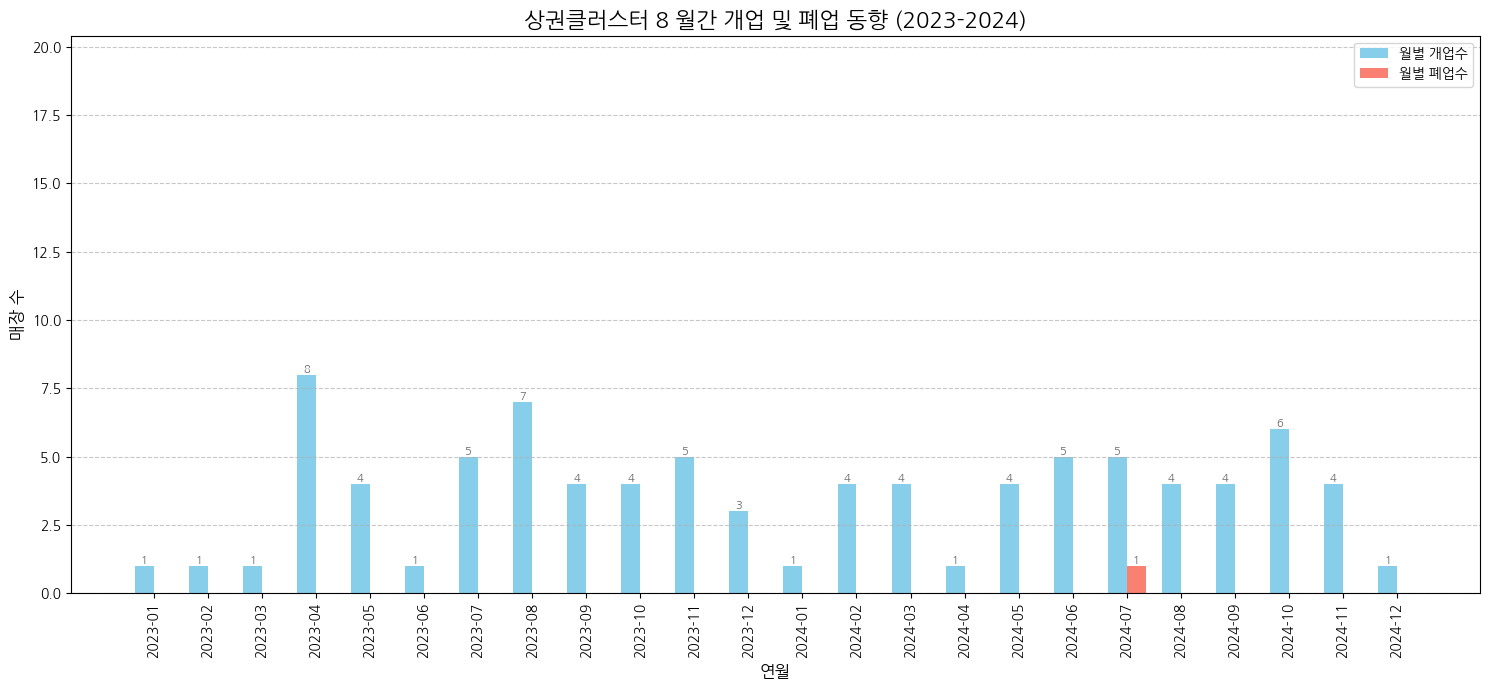

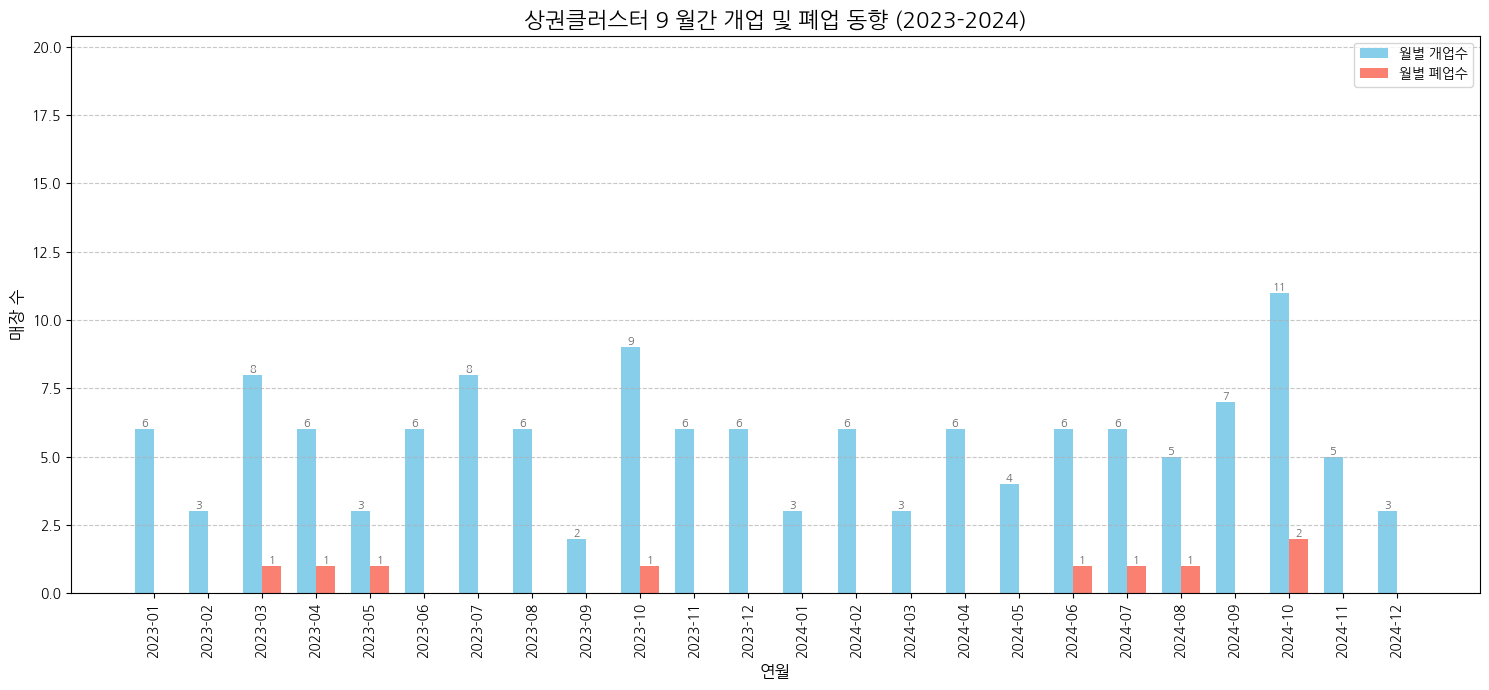

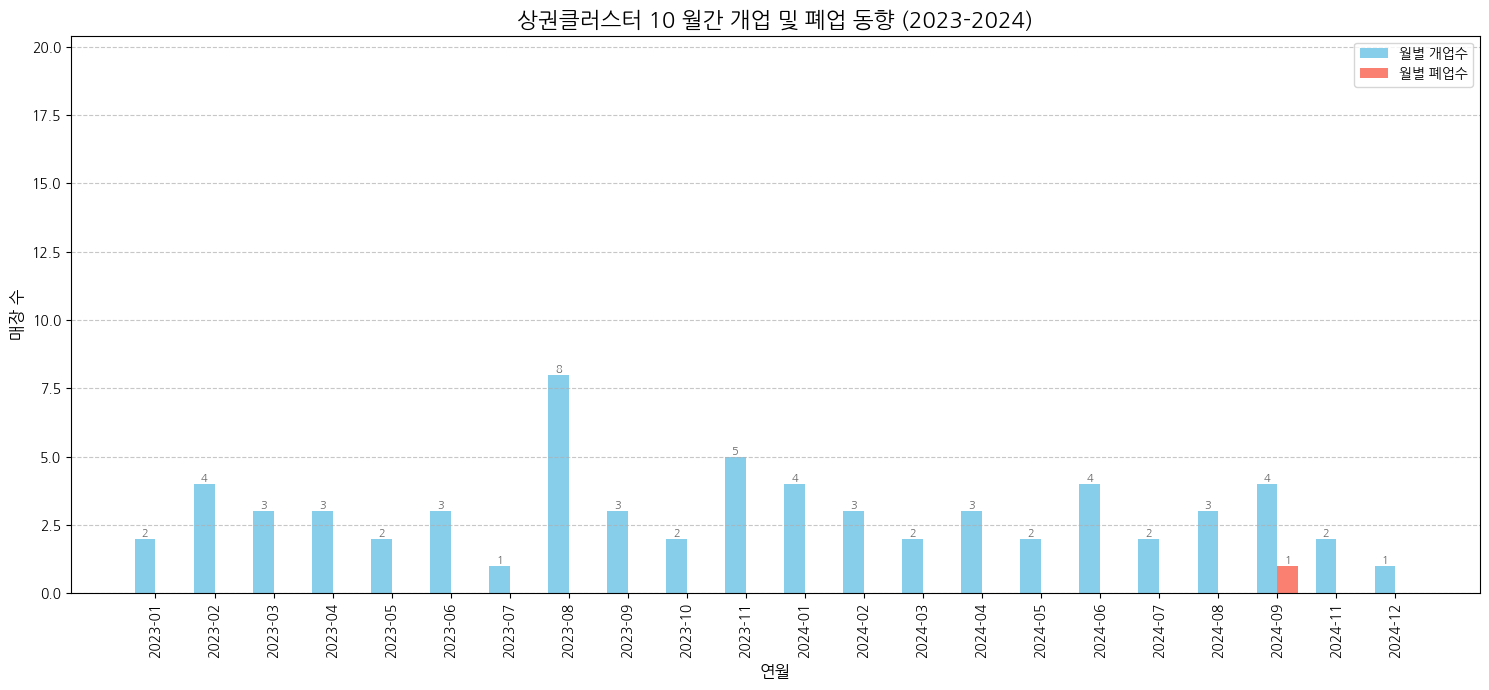

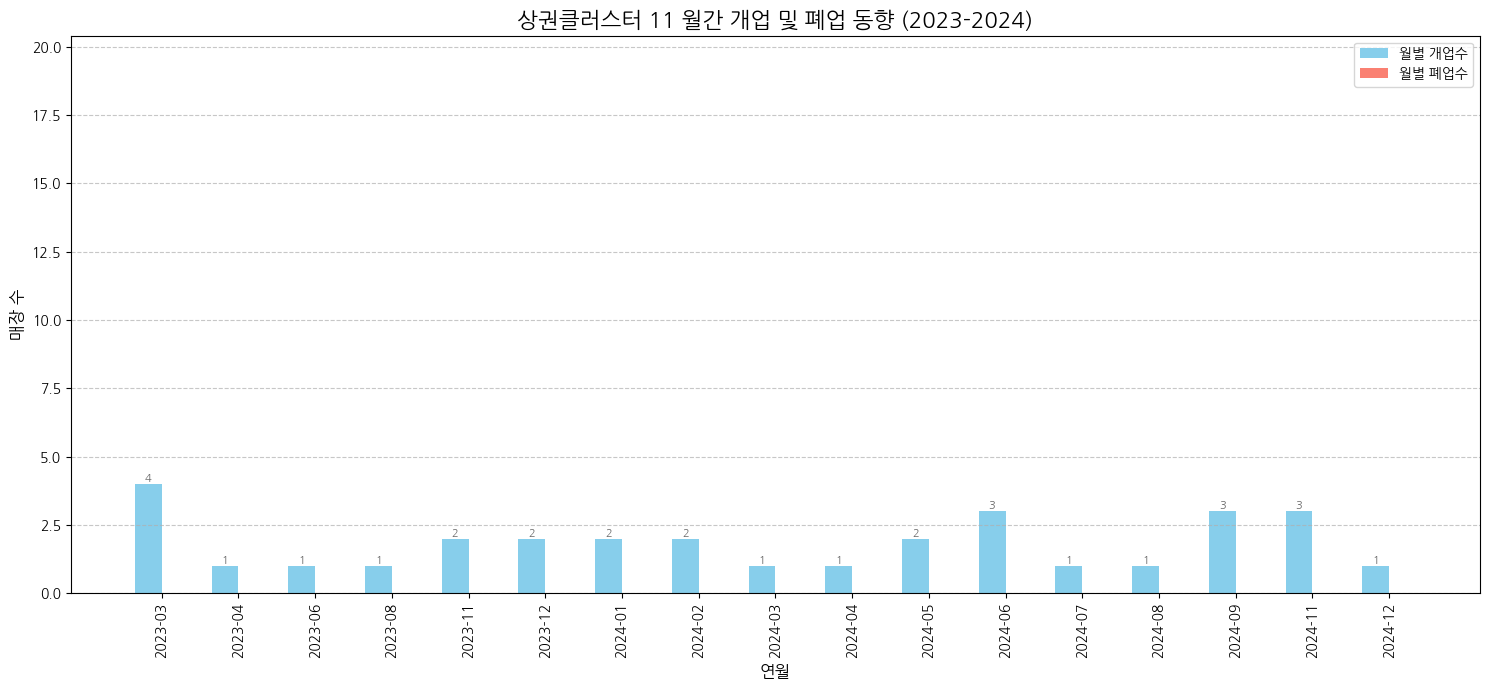

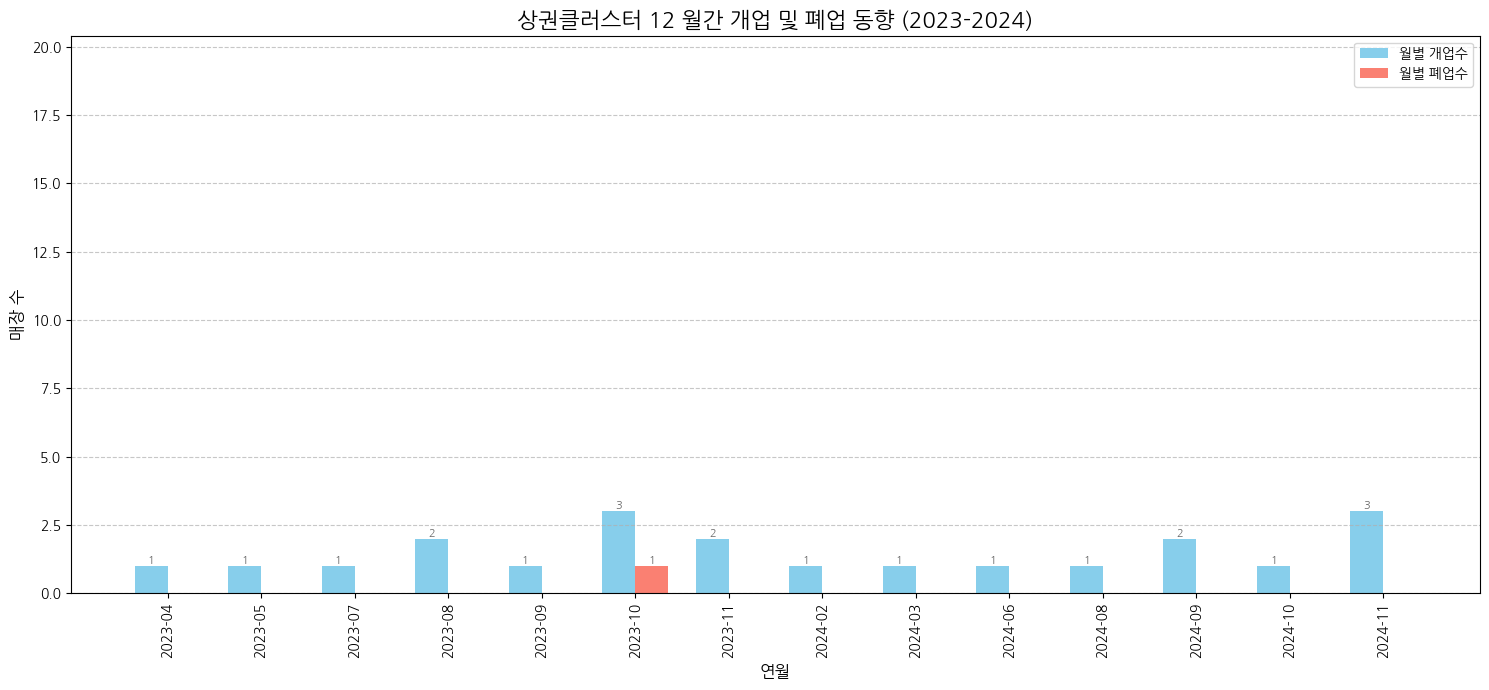

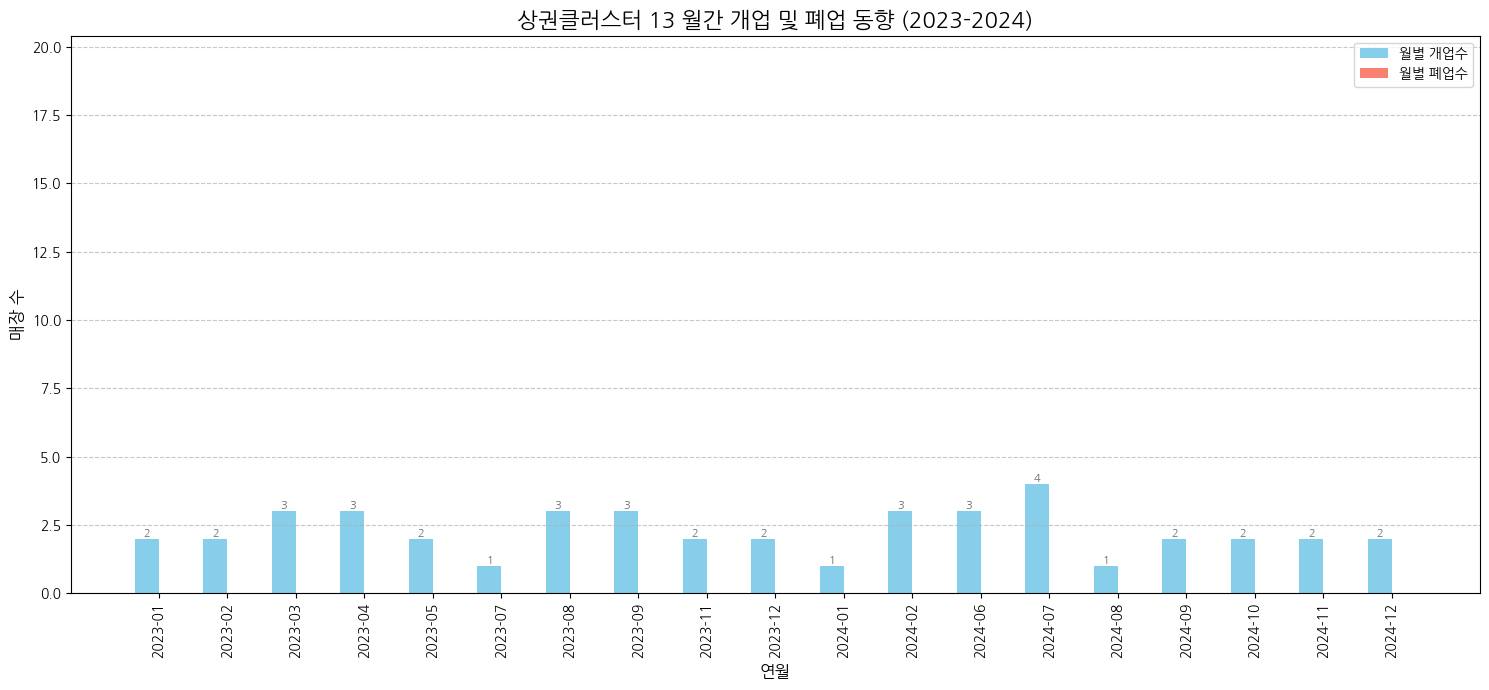

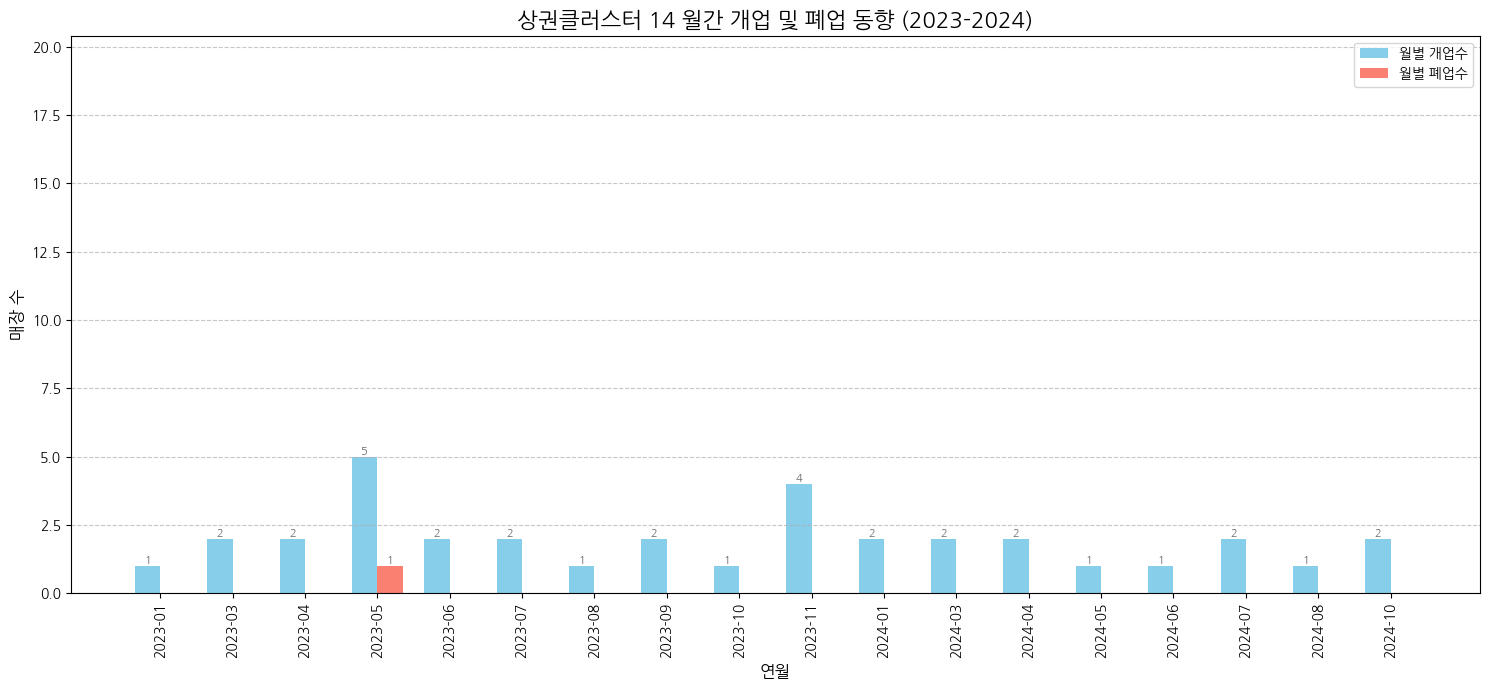

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Determine the global maximum value for y-axis across all clusters for openings and closings
global_max_count = max(monthly_trends['월별_개업수'].max(), monthly_trends['월별_폐업수'].max())
y_max_limit = global_max_count * 1.2 # Add 20% padding for text labels

unique_clusters = monthly_trends['상권클러스터'].unique()

for cluster_id in sorted(unique_clusters):
    cluster_data = monthly_trends[monthly_trends['상권클러스터'] == cluster_id].sort_values(['연도', '월']).copy()

    # Create a 'YYYY-MM' format for x-axis labels
    cluster_data.loc[:, '연월'] = cluster_data['연도'].astype(str) + '-' + cluster_data['월'].astype(str).str.zfill(2)

    fig, ax = plt.subplots(figsize=(15, 7))

    bar_width = 0.35
    index = np.arange(len(cluster_data['연월']))

    # Plot openings and closings as grouped bars
    p1 = ax.bar(index - bar_width/2, cluster_data['월별_개업수'], bar_width, label='월별 개업수', color='skyblue')
    p2 = ax.bar(index + bar_width/2, cluster_data['월별_폐업수'], bar_width, label='월별 폐업수', color='salmon')

    # Add text labels on top of each bar
    for bar in p1:
        height = bar.get_height()
        if height > 0: # Only annotate if there's a bar
            ax.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8, color='dimgray')
    for bar in p2:
        height = bar.get_height()
        if height > 0: # Only annotate if there's a bar
            ax.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8, color='dimgray')

    ax.set_xlabel('연월', fontsize=12)
    ax.set_ylabel('매장 수', fontsize=12)
    ax.set_title(f'상권클러스터 {int(cluster_id)} 월간 개업 및 폐업 동향 (2023-2024)', fontsize=16)
    ax.set_xticks(index)
    ax.set_xticklabels(cluster_data['연월'], rotation=90, fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Set consistent y-axis limit
    ax.set_ylim(0, y_max_limit)

    plt.tight_layout()
    plt.show()

# 가설 통계검정

## 12개월_업종대비_평균매출_비율 과 폐업
-> 유의함

In [ ]:
operating_stores_sales_ratio = df_cleaned[df_cleaned['폐업여부'] == 0]['12개월_업종대비_평균매출_비율']
print(f"운영 중인 가맹점의 '12개월_업종대비_평균매출_비율' 데이터 수: {len(operating_stores_sales_ratio)}개")

운영 중인 가맹점의 '12개월_업종대비_평균매출_비율' 데이터 수: 82389개


In [ ]:
closed_23_24_sales_ratio = df_filtered_closed_23_24['12개월_업종대비_평균매출_비율']
print(f"2023/2024년 폐업 가맹점의 '12개월_업종대비_평균매출_비율' 데이터 수: {len(closed_23_24_sales_ratio)}개")

2023/2024년 폐업 가맹점의 '12개월_업종대비_평균매출_비율' 데이터 수: 346개


In [ ]:
t_statistic_retest, p_value_retest = ttest_ind(closed_23_24_sales_ratio, operating_stores_sales_ratio, equal_var=False)

print(f"T-statistic (retest for 2023/2024 closed vs operating stores): {t_statistic_retest:.3f}")
print(f"P-value (retest for 2023/2024 closed vs operating stores): {p_value_retest:.3f}")

T-statistic (retest for 2023/2024 closed vs operating stores): -2.823
P-value (retest for 2023/2024 closed vs operating stores): 0.005


In [ ]:
df_retest_plot = pd.DataFrame({
    '12개월_업종대비_평균매출_비율': pd.concat([operating_stores_sales_ratio, closed_23_24_sales_ratio]),
    'Group': ['운영 중인 가맹점'] * len(operating_stores_sales_ratio) + ['2023/2024년 폐업 가맹점'] * len(closed_23_24_sales_ratio)
})

print(df_retest_plot.head())
print(df_retest_plot.tail())

   12개월_업종대비_평균매출_비율      Group
0               70.4  운영 중인 가맹점
1               74.6  운영 중인 가맹점
2               85.6  운영 중인 가맹점
3               90.5  운영 중인 가맹점
4               81.1  운영 중인 가맹점
       12개월_업종대비_평균매출_비율              Group
85797               49.5  2023/2024년 폐업 가맹점
85798               52.5  2023/2024년 폐업 가맹점
85799               27.5  2023/2024년 폐업 가맹점
85800               50.4  2023/2024년 폐업 가맹점
85801               42.7  2023/2024년 폐업 가맹점


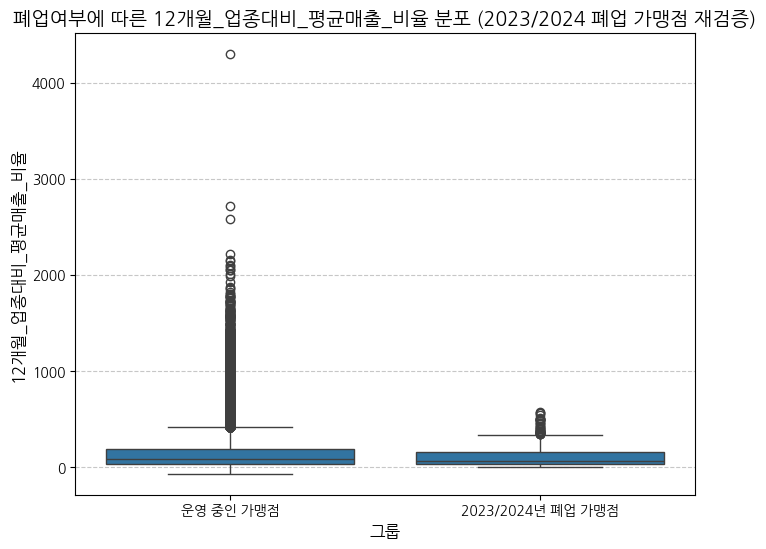

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='12개월_업종대비_평균매출_비율', data=df_retest_plot)
plt.title('폐업여부에 따른 12개월_업종대비_평균매출_비율 분포 (2023/2024 폐업 가맹점 재검증)', fontsize=14)
plt.xlabel('그룹', fontsize=12)
plt.ylabel('12개월_업종대비_평균매출_비율', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 취소율_구간과 폐업
-> 유의하지 않음

In [ ]:
operating_stores_cancel_ratio = df_cleaned[df_cleaned['폐업여부'] == 0]['취소율_구간']
print(f"운영 중인 가맹점의 '취소율_구간' 데이터 수: {len(operating_stores_cancel_ratio)}개")

운영 중인 가맹점의 '취소율_구간' 데이터 수: 82389개


In [ ]:
closed_23_24_cancel_ratio = df_filtered_closed_23_24['취소율_구간']
print(f"2023/2024년 폐업 가맹점의 '취소율_구간' 데이터 수: {len(closed_23_24_cancel_ratio)}개")

2023/2024년 폐업 가맹점의 '취소율_구간' 데이터 수: 346개


In [ ]:
t_statistic_cancel_retest, p_value_cancel_retest = ttest_ind(closed_23_24_cancel_ratio, operating_stores_cancel_ratio, equal_var=False)

print(f"T-statistic (retest for 2023/2024 closed vs operating stores): {t_statistic_cancel_retest:.3f}")
print(f"P-value (retest for 2023/2024 closed vs operating stores): {p_value_cancel_retest:.3f}")

T-statistic (retest for 2023/2024 closed vs operating stores): -0.029
P-value (retest for 2023/2024 closed vs operating stores): 0.977


In [ ]:
df_retest_plot_cancel = pd.DataFrame({
    '취소율_구간': pd.concat([operating_stores_cancel_ratio, closed_23_24_cancel_ratio]),
    'Group': ['운영 중인 가맹점'] * len(operating_stores_cancel_ratio) + ['2023/2024년 폐업 가맹점'] * len(closed_23_24_cancel_ratio)
})

print(df_retest_plot_cancel.head())
print(df_retest_plot_cancel.tail())

   취소율_구간      Group
0       6  운영 중인 가맹점
1       6  운영 중인 가맹점
2       1  운영 중인 가맹점
3       1  운영 중인 가맹점
4       1  운영 중인 가맹점
       취소율_구간              Group
85797       1  2023/2024년 폐업 가맹점
85798       3  2023/2024년 폐업 가맹점
85799       1  2023/2024년 폐업 가맹점
85800       6  2023/2024년 폐업 가맹점
85801       5  2023/2024년 폐업 가맹점


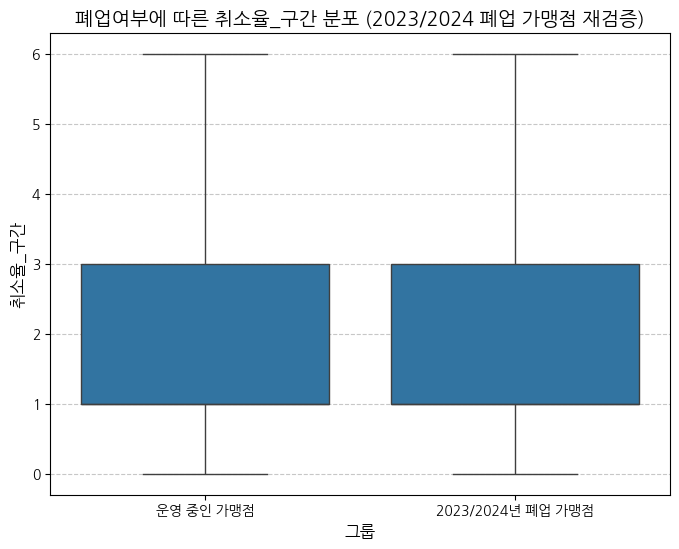

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='취소율_구간', data=df_retest_plot_cancel)
plt.title('폐업여부에 따른 취소율_구간 분포 (2023/2024 폐업 가맹점 재검증)', fontsize=14)
plt.xlabel('그룹', fontsize=12)
plt.ylabel('취소율_구간', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 재방문 고객_비중 및 신규고객_비중 과 폐업
-> 유의함

In [ ]:
operating_stores_revisit_ratio = df_cleaned[df_cleaned['폐업여부'] == 0]['재방문고객_비중']
print(f"운영 중인 가맹점의 '재방문고객_비중' 데이터 수: {len(operating_stores_revisit_ratio)}개")

운영 중인 가맹점의 '재방문고객_비중' 데이터 수: 82389개


In [ ]:
closed_23_24_revisit_ratio = df_filtered_closed_23_24['재방문고객_비중']
print(f"2023/2024년 폐업 가맹점의 '재방문고객_비중' 데이터 수: {len(closed_23_24_revisit_ratio)}개")

2023/2024년 폐업 가맹점의 '재방문고객_비중' 데이터 수: 346개


In [ ]:
t_statistic_revisit_retest, p_value_revisit_retest = ttest_ind(closed_23_24_revisit_ratio, operating_stores_revisit_ratio, equal_var=False)

print(f"T-statistic (retest for 2023/2024 closed vs operating stores, 재방문고객_비중): {t_statistic_revisit_retest:.3f}")
print(f"P-value (retest for 2023/2024 closed vs operating stores, 재방문고객_비중): {p_value_revisit_retest:.3f}")

T-statistic (retest for 2023/2024 closed vs operating stores, 재방문고객_비중): -3.948
P-value (retest for 2023/2024 closed vs operating stores, 재방문고객_비중): 0.000


In [ ]:
operating_stores_new_customer_ratio = df_cleaned[df_cleaned['폐업여부'] == 0]['신규고객_비중']
print(f"운영 중인 가맹점의 '신규고객_비중' 데이터 수: {len(operating_stores_new_customer_ratio)}개")

운영 중인 가맹점의 '신규고객_비중' 데이터 수: 82389개


In [ ]:
closed_23_24_new_customer_ratio = df_filtered_closed_23_24['신규고객_비중']
print(f"2023/2024년 폐업 가맹점의 '신규고객_비중' 데이터 수: {len(closed_23_24_new_customer_ratio)}개")

2023/2024년 폐업 가맹점의 '신규고객_비중' 데이터 수: 346개


In [ ]:
from scipy.stats import ttest_ind

t_statistic_new_customer_retest, p_value_new_customer_retest = ttest_ind(closed_23_24_new_customer_ratio, operating_stores_new_customer_ratio, equal_var=False)

print(f"T-statistic (retest for 2023/2024 closed vs operating stores, 신규고객_비중): {t_statistic_new_customer_retest:.3f}")
print(f"P-value (retest for 2023/2024 closed vs operating stores, 신규고객_비중): {p_value_new_customer_retest:.3f}")

T-statistic (retest for 2023/2024 closed vs operating stores, 신규고객_비중): -2.698
P-value (retest for 2023/2024 closed vs operating stores, 신규고객_비중): 0.007


In [ ]:
df_retest_plot_revisit = pd.DataFrame({
    '고객_비중': pd.concat([operating_stores_revisit_ratio, closed_23_24_revisit_ratio]),
    'Group': ['운영 중인 가맹점'] * len(operating_stores_revisit_ratio) + ['2023/2024년 폐업 가맹점'] * len(closed_23_24_revisit_ratio),
    'Metric': ['재방문고객_비중'] * (len(operating_stores_revisit_ratio) + len(closed_23_24_revisit_ratio))
})

print(df_retest_plot_revisit.head())
print(df_retest_plot_revisit.tail())

   고객_비중      Group    Metric
0  18.82  운영 중인 가맹점  재방문고객_비중
1  16.51  운영 중인 가맹점  재방문고객_비중
2  16.98  운영 중인 가맹점  재방문고객_비중
3  16.95  운영 중인 가맹점  재방문고객_비중
4  20.96  운영 중인 가맹점  재방문고객_비중
       고객_비중              Group    Metric
85797  60.10  2023/2024년 폐업 가맹점  재방문고객_비중
85798  59.90  2023/2024년 폐업 가맹점  재방문고객_비중
85799  55.82  2023/2024년 폐업 가맹점  재방문고객_비중
85800  56.06  2023/2024년 폐업 가맹점  재방문고객_비중
85801  58.62  2023/2024년 폐업 가맹점  재방문고객_비중


In [ ]:
df_retest_plot_new_customer = pd.DataFrame({
    '고객_비중': pd.concat([operating_stores_new_customer_ratio, closed_23_24_new_customer_ratio]),
    'Group': ['운영 중인 가맹점'] * len(operating_stores_new_customer_ratio) + ['2023/2024년 폐업 가맹점'] * len(closed_23_24_new_customer_ratio),
    'Metric': ['신규고객_비중'] * (len(operating_stores_new_customer_ratio) + len(closed_23_24_new_customer_ratio))
})

print(df_retest_plot_new_customer.head())
print(df_retest_plot_new_customer.tail())

   고객_비중      Group   Metric
0   6.47  운영 중인 가맹점  신규고객_비중
1   5.05  운영 중인 가맹점  신규고객_비중
2   6.60  운영 중인 가맹점  신규고객_비중
3   9.60  운영 중인 가맹점  신규고객_비중
4   4.79  운영 중인 가맹점  신규고객_비중
       고객_비중              Group   Metric
85797   4.99  2023/2024년 폐업 가맹점  신규고객_비중
85798   5.84  2023/2024년 폐업 가맹점  신규고객_비중
85799   2.38  2023/2024년 폐업 가맹점  신규고객_비중
85800   4.80  2023/2024년 폐업 가맹점  신규고객_비중
85801   6.90  2023/2024년 폐업 가맹점  신규고객_비중


In [ ]:
df_retest_plot_combined_customers = pd.concat([df_retest_plot_revisit, df_retest_plot_new_customer])

print(df_retest_plot_combined_customers.head())
print(df_retest_plot_combined_customers.tail())

   고객_비중      Group    Metric
0  18.82  운영 중인 가맹점  재방문고객_비중
1  16.51  운영 중인 가맹점  재방문고객_비중
2  16.98  운영 중인 가맹점  재방문고객_비중
3  16.95  운영 중인 가맹점  재방문고객_비중
4  20.96  운영 중인 가맹점  재방문고객_비중
       고객_비중              Group   Metric
85797   4.99  2023/2024년 폐업 가맹점  신규고객_비중
85798   5.84  2023/2024년 폐업 가맹점  신규고객_비중
85799   2.38  2023/2024년 폐업 가맹점  신규고객_비중
85800   4.80  2023/2024년 폐업 가맹점  신규고객_비중
85801   6.90  2023/2024년 폐업 가맹점  신규고객_비중


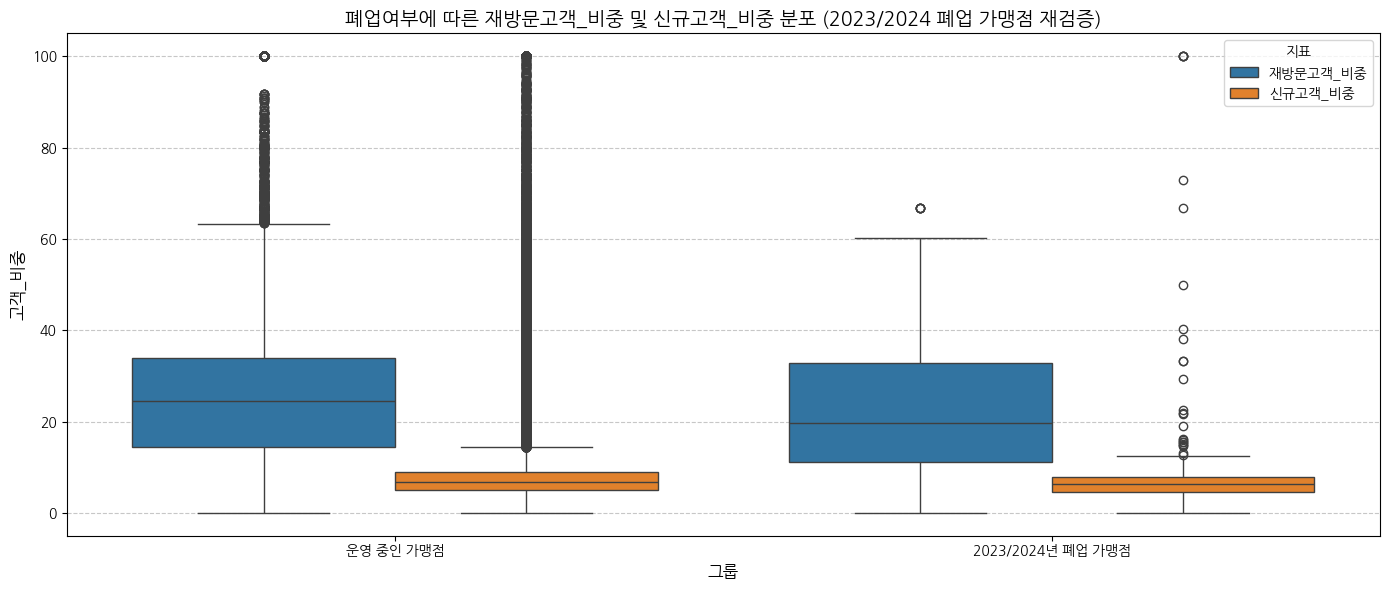

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Group', y='고객_비중', hue='Metric', data=df_retest_plot_combined_customers)
plt.title('폐업여부에 따른 재방문고객_비중 및 신규고객_비중 분포 (2023/2024 폐업 가맹점 재검증)', fontsize=14)
plt.xlabel('그룹', fontsize=12)
plt.ylabel('고객_비중', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='지표')
plt.tight_layout()
plt.show()

## 객단가_구간
-> 유의하지 않음

In [ ]:
missing_values_gakedanga = df_final['객단가_구간'].isnull().sum()
print(f"'객단가_구간' 컬럼의 결측치 개수 (처리 전): {missing_values_gakedanga}개")

df_cleaned_for_gakedanga = df_final.dropna(subset=['폐업여부', '객단가_구간']).copy()

print(f"'객단가_구간' 컬럼의 데이터 타입: {df_cleaned_for_gakedanga['객단가_구간'].dtype}")
print(f"'폐업여부' 컬럼의 데이터 타입: {df_cleaned_for_gakedanga['폐업여부'].dtype}")
print(f"결측치 처리 후 df_cleaned_for_gakedanga의 행 수: {len(df_cleaned_for_gakedanga)}")

'객단가_구간' 컬럼의 결측치 개수 (처리 전): 0개
'객단가_구간' 컬럼의 데이터 타입: int64
'폐업여부' 컬럼의 데이터 타입: int64
결측치 처리 후 df_cleaned_for_gakedanga의 행 수: 86278


In [ ]:
operating_stores_gakedanga = df_cleaned_for_gakedanga[df_cleaned_for_gakedanga['폐업여부'] == 0]['객단가_구간']
print(f"운영 중인 가맹점의 '객단가_구간' 데이터 수: {len(operating_stores_gakedanga)}개")

운영 중인 가맹점의 '객단가_구간' 데이터 수: 83944개


In [ ]:
closed_23_24_gakedanga = df_filtered_closed_23_24['객단가_구간']
print(f"2023/2024년 폐업 가맹점의 '객단가_구간' 데이터 수: {len(closed_23_24_gakedanga)}개")

2023/2024년 폐업 가맹점의 '객단가_구간' 데이터 수: 346개


In [ ]:
t_statistic_gakedanga_retest, p_value_gakedanga_retest = ttest_ind(closed_23_24_gakedanga, operating_stores_gakedanga, equal_var=False)

print(f"T-statistic (retest for 2023/2024 closed vs operating stores, 객단가_구간): {t_statistic_gakedanga_retest:.3f}")
print(f"P-value (retest for 2023/2024 closed vs operating stores, 객단가_구간): {p_value_gakedanga_retest:.3f}")

T-statistic (retest for 2023/2024 closed vs operating stores, 객단가_구간): 1.814
P-value (retest for 2023/2024 closed vs operating stores, 객단가_구간): 0.070


In [ ]:
df_retest_plot_gakedanga = pd.DataFrame({
    '객단가_구간': pd.concat([operating_stores_gakedanga, closed_23_24_gakedanga]),
    'Group': ['운영 중인 가맹점'] * len(operating_stores_gakedanga) + ['2023/2024년 폐업 가맹점'] * len(closed_23_24_gakedanga)
})

print(df_retest_plot_gakedanga.head())
print(df_retest_plot_gakedanga.tail())

   객단가_구간      Group
0       2  운영 중인 가맹점
1       2  운영 중인 가맹점
2       2  운영 중인 가맹점
3       1  운영 중인 가맹점
4       1  운영 중인 가맹점
       객단가_구간              Group
85797       5  2023/2024년 폐업 가맹점
85798       5  2023/2024년 폐업 가맹점
85799       5  2023/2024년 폐업 가맹점
85800       5  2023/2024년 폐업 가맹점
85801       5  2023/2024년 폐업 가맹점


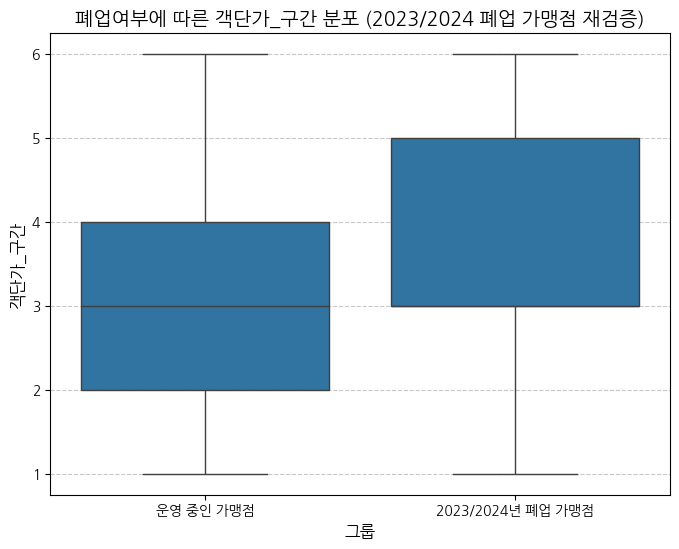

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='객단가_구간', data=df_retest_plot_gakedanga)
plt.title('폐업여부에 따른 객단가_구간 분포 (2023/2024 폐업 가맹점 재검증)', fontsize=14)
plt.xlabel('그룹', fontsize=12)
plt.ylabel('객단가_구간', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 월매출_건수
-> 유의하지 않음

In [ ]:
missing_values_sales_count = df_final['월매출건수_구간'].isnull().sum()
print(f"'월매출건수_구간' 컬럼의 결측치 개수 (처리 전): {missing_values_sales_count}개")

df_cleaned_for_sales_count = df_final.dropna(subset=['폐업여부', '월매출건수_구간']).copy()

print(f"'월매출건수_구간' 컬럼의 데이터 타입: {df_cleaned_for_sales_count['월매출건수_구간'].dtype}")
print(f"'폐업여부' 컬럼의 데이터 타입: {df_cleaned_for_sales_count['폐업여부'].dtype}")
print(f"결측치 처리 후 df_cleaned_for_sales_count의 행 수: {len(df_cleaned_for_sales_count)}")

'월매출건수_구간' 컬럼의 결측치 개수 (처리 전): 0개
'월매출건수_구간' 컬럼의 데이터 타입: int64
'폐업여부' 컬럼의 데이터 타입: int64
결측치 처리 후 df_cleaned_for_sales_count의 행 수: 86278


In [ ]:
operating_stores_sales_count = df_cleaned_for_sales_count[df_cleaned_for_sales_count['폐업여부'] == 0]['월매출건수_구간']
print(f"운영 중인 가맹점의 '월매출건수_구간' 데이터 수: {len(operating_stores_sales_count)}개")

운영 중인 가맹점의 '월매출건수_구간' 데이터 수: 83944개


In [ ]:
closed_23_24_sales_count = df_filtered_closed_23_24['월매출건수_구간']
print(f"2023/2024년 폐업 가맹점의 '월매출건수_구간' 데이터 수: {len(closed_23_24_sales_count)}개")

2023/2024년 폐업 가맹점의 '월매출건수_구간' 데이터 수: 346개


In [ ]:
t_statistic_sales_count_retest, p_value_sales_count_retest = ttest_ind(closed_23_24_sales_count, operating_stores_sales_count, equal_var=False)

print(f"T-statistic (retest for 2023/2024 closed vs operating stores, 월매출건수_구간): {t_statistic_sales_count_retest:.3f}")
print(f"P-value (retest for 2023/2024 closed vs operating stores, 월매출건수_구간): {p_value_sales_count_retest:.3f}")

T-statistic (retest for 2023/2024 closed vs operating stores, 월매출건수_구간): 1.721
P-value (retest for 2023/2024 closed vs operating stores, 월매출건수_구간): 0.086


In [ ]:
df_retest_plot_sales_count = pd.DataFrame({
    '월매출건수_구간': pd.concat([operating_stores_sales_count, closed_23_24_sales_count]),
    'Group': ['운영 중인 가맹점'] * len(operating_stores_sales_count) + ['2023/2024년 폐업 가맹점'] * len(closed_23_24_sales_count)
})

print(df_retest_plot_sales_count.head())
print(df_retest_plot_sales_count.tail())

   월매출건수_구간      Group
0         4  운영 중인 가맹점
1         4  운영 중인 가맹점
2         4  운영 중인 가맹점
3         4  운영 중인 가맹점
4         4  운영 중인 가맹점
       월매출건수_구간              Group
85797         2  2023/2024년 폐업 가맹점
85798         2  2023/2024년 폐업 가맹점
85799         3  2023/2024년 폐업 가맹점
85800         3  2023/2024년 폐업 가맹점
85801         3  2023/2024년 폐업 가맹점


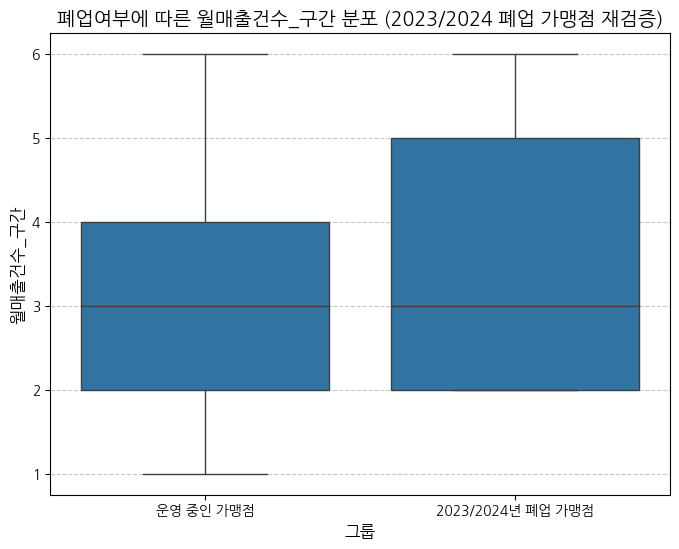

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='월매출건수_구간', data=df_retest_plot_sales_count)
plt.title('폐업여부에 따른 월매출건수_구간 분포 (2023/2024 폐업 가맹점 재검증)', fontsize=14)
plt.xlabel('그룹', fontsize=12)
plt.ylabel('월매출건수_구간', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 가중치 분석

## 매출과 고객비중

In [ ]:
import statsmodels.api as sm

y = merged_df['12개월_업종내_매출_백분위']
X = merged_df[['신규고객_비중_cleaned', '재방문고객_비중_cleaned', '유동인구고객_비중_cleaned']]
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        12개월_업종내_매출_백분위   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     4945.
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:13:50   Log-Likelihood:            -3.5961e+05
No. Observations:               80394   AIC:                         7.192e+05
Df Residuals:                   80390   BIC:                         7.193e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                37.2030      0.27

In [ ]:
import statsmodels.api as sm

y_sales_segment_reranked = merged_df['월매출_구간']
X_ind = merged_df[['신규고객_비중_cleaned', '재방문고객_비중_cleaned', '유동인구고객_비중_cleaned']]
X_sales_segment_reranked = sm.add_constant(X_ind)

model_sales_segment_reranked = sm.OLS(y_sales_segment_reranked, X_sales_segment_reranked)
results_sales_segment_reranked = model_sales_segment_reranked.fit()
print(results_sales_segment_reranked.summary())

                            OLS Regression Results                            
Dep. Variable:                 월매출_구간   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2662.
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:13:50   Log-Likelihood:            -1.3356e+05
No. Observations:               80394   AIC:                         2.671e+05
Df Residuals:                   80390   BIC:                         2.672e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.8080      0.01

In [ ]:
import statsmodels.api as sm

y_sales_count_segment_reranked = merged_df['월매출건수_구간']
X_ind = merged_df[['신규고객_비중_cleaned', '재방문고객_비중_cleaned', '유동인구고객_비중_cleaned']]
X_sales_count_segment_reranked = sm.add_constant(X_ind)

model_sales_count_segment_reranked = sm.OLS(y_sales_count_segment_reranked, X_sales_count_segment_reranked)
results_sales_count_segment_reranked = model_sales_count_segment_reranked.fit()
print(results_sales_count_segment_reranked.summary())

                            OLS Regression Results                            
Dep. Variable:               월매출건수_구간   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     2586.
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:13:50   Log-Likelihood:            -1.3179e+05
No. Observations:               80394   AIC:                         2.636e+05
Df Residuals:                   80390   BIC:                         2.636e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.3321      0.01

## 매출과 상권 클러스터

In [ ]:
import statsmodels.api as sm

y_percentile = new_merged_df['12개월_업종내_매출_백분위']
X_clusters = new_merged_df[['역동적 과도기형상권', '불안정 침체형상권', '지속 성장형상권', '정체 고착형상권']]
X_clusters = sm.add_constant(X_clusters)

model_percentile = sm.OLS(y_percentile, X_clusters)
results_percentile = model_percentile.fit()
print(results_percentile.summary())

                            OLS Regression Results                            
Dep. Variable:        12개월_업종내_매출_백분위   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     679.8
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:13:51   Log-Likelihood:            -3.6541e+05
No. Observations:               80394   AIC:                         7.308e+05
Df Residuals:                   80390   BIC:                         7.309e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.4456      0.073    322.225      0.0

In [ ]:
import statsmodels.api as sm

y_sales_segment_reranked = new_merged_df['월매출_구간']
X_clusters = new_merged_df[['역동적 과도기형상권', '불안정 침체형상권', '지속 성장형상권', '정체 고착형상권']]
X_clusters = sm.add_constant(X_clusters)

model_sales_segment_reranked = sm.OLS(y_sales_segment_reranked, X_clusters)
results_sales_segment_reranked = model_sales_segment_reranked.fit()
print(results_sales_segment_reranked.summary())

                            OLS Regression Results                            
Dep. Variable:                 월매출_구간   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     882.4
Date:                Fri, 14 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:47:12   Log-Likelihood:            -1.3607e+05
No. Observations:               80394   AIC:                         2.721e+05
Df Residuals:                   80390   BIC:                         2.722e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8914      0.004    688.915      0.0

In [ ]:
import statsmodels.api as sm

y_sales_count_segment_reranked = new_merged_df['월매출건수_구간']
X_clusters = new_merged_df[['역동적 과도기형상권', '불안정 침체형상권', '지속 성장형상권', '정체 고착형상권']]
X_clusters = sm.add_constant(X_clusters)

model_sales_count_segment_reranked = sm.OLS(y_sales_count_segment_reranked, X_clusters)
results_sales_count_segment_reranked = model_sales_count_segment_reranked.fit()
print(results_sales_count_segment_reranked.summary())

                            OLS Regression Results                            
Dep. Variable:               월매출건수_구간   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1123.
Date:                Fri, 14 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:47:23   Log-Likelihood:            -1.3385e+05
No. Observations:               80394   AIC:                         2.677e+05
Df Residuals:                   80390   BIC:                         2.677e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9424      0.004    720.693      0.0